# Stroke Prediction Project

Strokes are one of the leading causes of death and disability worldwide. Early detection and prediction of stroke risk can lead to better treatment outcomes and improved patient prognoses. This project aims to analyse how machine learning can help with that.

Machine learning algorithms can be used to analyze large amounts of data to identify patterns and correlations that may be indicative of an increased risk of stroke. This information can then be used to design targeted prevention strategies, such as lifestyle modifications, to reduce an individual's risk of stroke.

In addition, machine learning can help identify high-risk individuals who may benefit from more intensive screening and monitoring. This can allow healthcare providers to take proactive steps to prevent stroke before it occurs, potentially saving lives and reducing the burden of stroke on healthcare systems.

Overall, the ability of machine learning to analyze vast amounts of data, identify risk factors, and make predictions about future health outcomes makes it a valuable tool for the early detection and prevention of stroke.

The goal of this project is to analyse the data from [Stroke Prediction Dataset](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) and create a model which can predict whether ths "stroke" column in the dataset.

This analysis can help in order to prevent stroke for people which are at high risk. The project contains these parts:

## Table of contents
1. [Data Cleaning](#data_cleaning) 
2. [Exploratory Data Analysis](#data_exploration) 
3. [Feature Exploration](#feature_exploration) 
4. [Stroke Prediction](#stroke_pred) 
5. [Deploying Model](#deploying_model) 
6. [Summary](#summary) 


## How would ML model help for hospitals?
A machine learning model that predicts stroke can help a hospital in several ways:

* **Early detection**: The model can help detect the risk of stroke in patients, even before the symptoms are apparent. This early detection can help the hospital take proactive measures to prevent the stroke from happening or to minimize its impact.

* **Personalized treatment**: By analyzing patient data, the model can predict which treatments are most likely to be effective for each individual patient, helping the hospital tailor treatments to the specific needs of each patient.

* **Improved patient outcomes**: By detecting stroke risk and tailoring treatments, the model can help improve patient outcomes and reduce the likelihood of complications.

* **Improved resource allocation**: The model can help the hospital allocate resources more effectively, for example by prioritizing high-risk patients for treatment, or by predicting which patients are likely to need additional care after discharge.

* **Reduced costs**: By improving patient outcomes and resource allocation, the model can help the hospital reduce costs associated with stroke care, such as readmissions and prolonged hospital stays.

Overall, a machine learning model that predicts stroke can help a hospital provide more efficient, effective, and personalized care to patients, leading to improved patient outcomes and reduced costs. Therefore, the objective of this project is to develop a model that aids healthcare practitioners in accurately identifying patients with a high risk of stroke, reducing the potential for human error. This will be done by minimizing false negatives.

In [679]:
import pandas as pd
import missingno as msno
import helpers as helper_functions
import shap

from autofeat import FeatureSelector
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.impute import KNNImputer 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score 
from xgboost import XGBClassifier
from joblib import dump
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder 
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder   

In [680]:
import warnings
warnings.filterwarnings('ignore')

In [681]:
""" Initialize shap module """
shap.initjs()

In [682]:
""" Read the dataset """
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

## <a id='data_cleaning'>1. Data Cleaning</a> 



First, of all I want to see whether there are missing values in the dataset.

We can see that only the bmi values for 201 entries are missing. Therefore, I will investigate how to impute them.

In [683]:
''' Display dataframe with number and percentage of missing values for each column '''
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(10)

Total   Percent
bmi                  201  0.039335
id                     0  0.000000
gender                 0  0.000000
age                    0  0.000000
hypertension           0  0.000000
heart_disease          0  0.000000
ever_married           0  0.000000
work_type              0  0.000000
Residence_type         0  0.000000
avg_glucose_level      0  0.000000

We can see the missing values in the msno matrix as well for better representation of what part of the dataset is missing.

Since there are 5110 rows in the data frame, the 201 missing entries is not a big loss.

<AxesSubplot: >

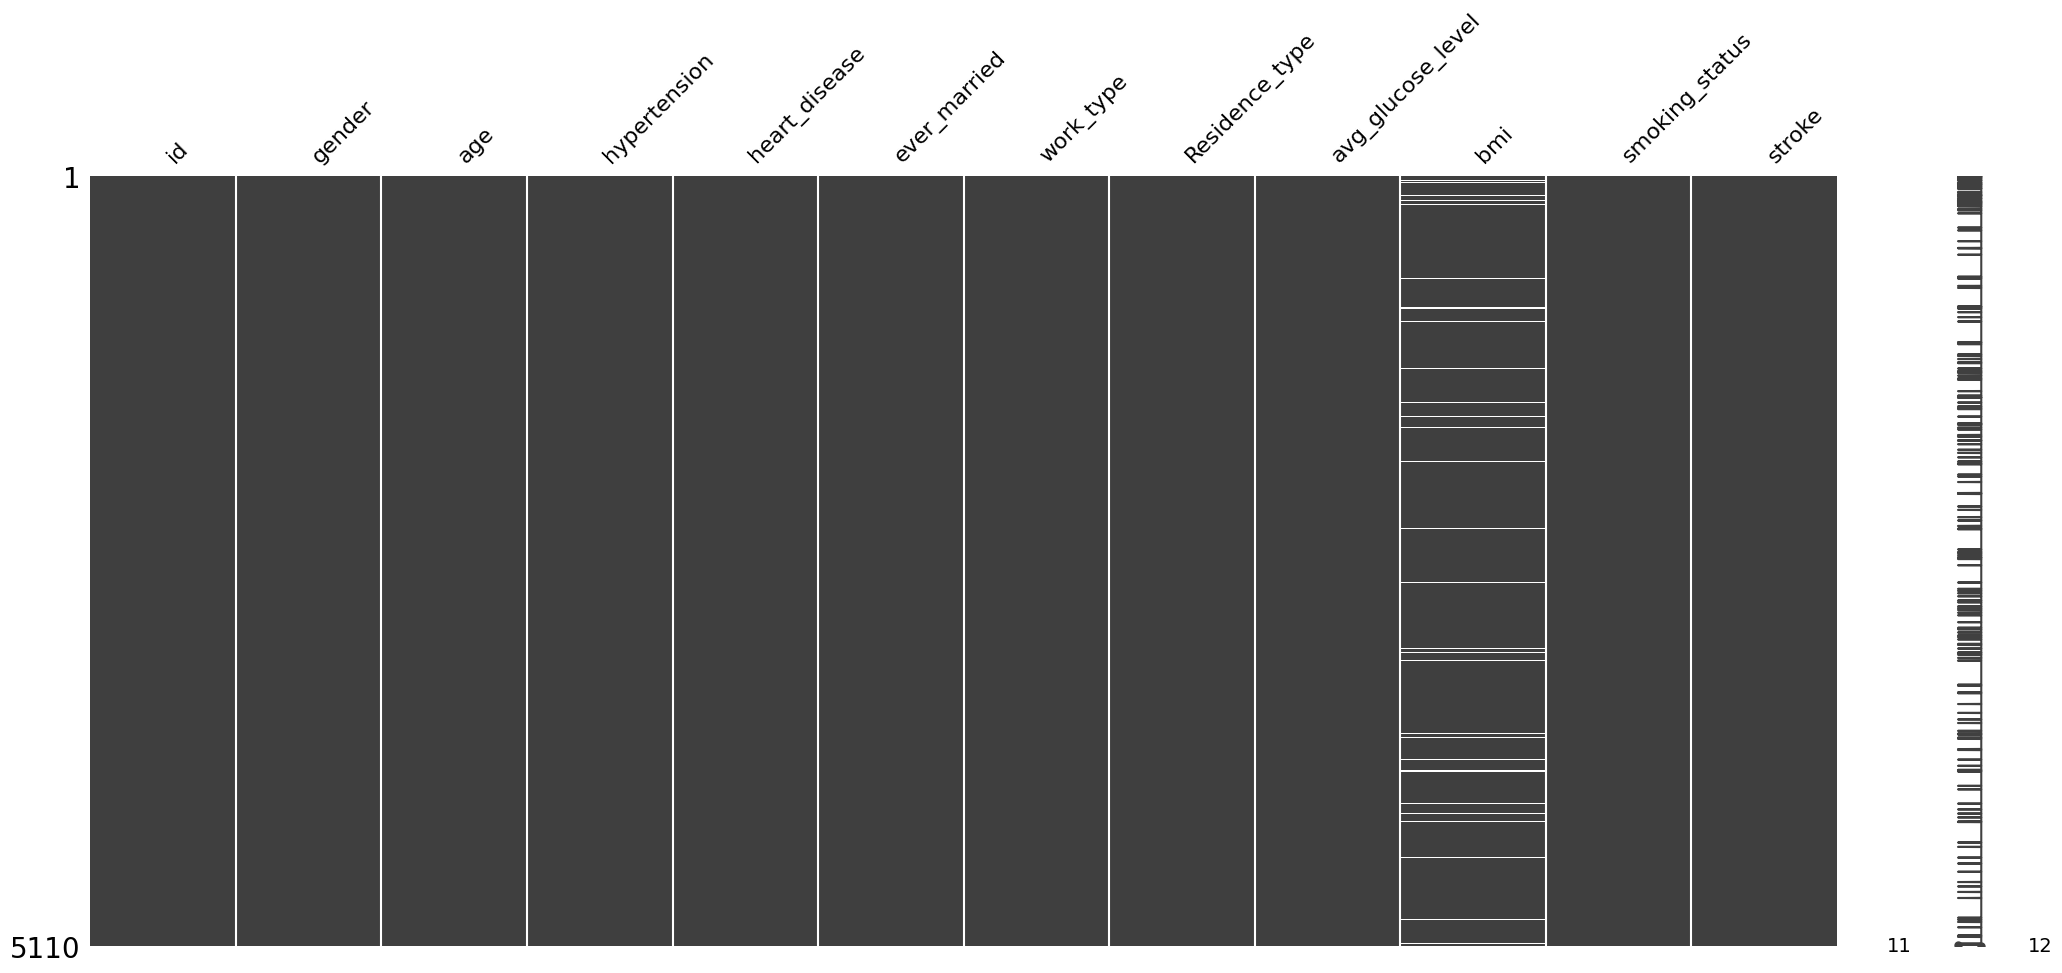

In [684]:
''' Display msno matrix to show missing values '''
msno.matrix(data)

First, I wanted to see the distributions of different features in order to select right imputing way.

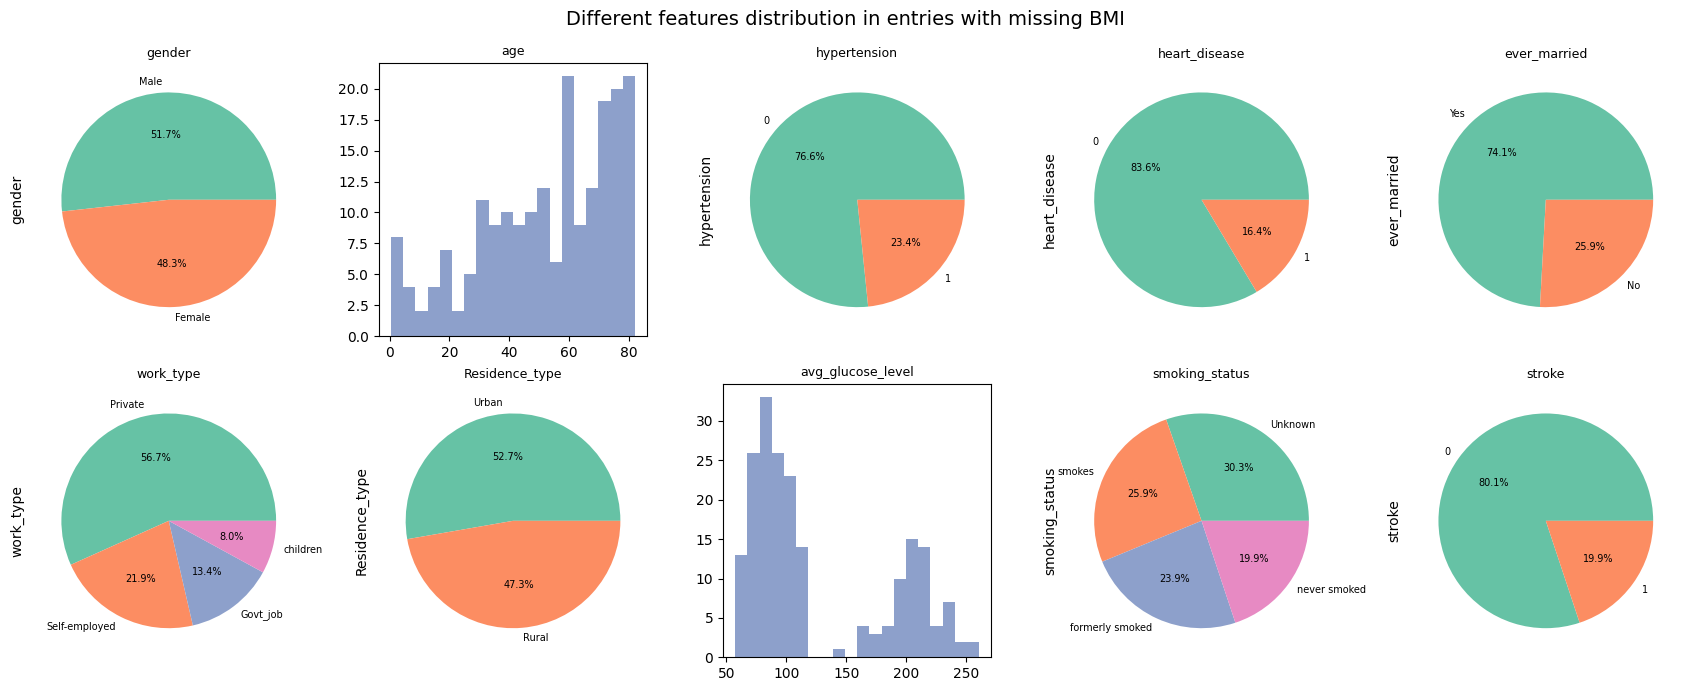

In [685]:
''' Plot distribution of all features '''
helper_functions.plot_distributions(data, "bmi")

For imputing missing values, I decided to use KNN imputer. It is a good approach for imputing missing values because it uses the information from the nearest neighbors of a missing data point to estimate its value. The idea behind KNN imputation is that a data point's value is more likely to be similar to the values of its close neighbors than to data points that are far away.

Therefore, my plan is to include this imputer to my model's pipeline which will help once model will be deployed because it will handle not only missing bmi value, but also other numeric features as well.

In [686]:
''' Impute Missing Values '''
num_cols = ['age', 'bmi', 'avg_glucose_level']
knn_imputer = KNNImputer(n_neighbors=5)  
df_cleaned = pd.DataFrame(knn_imputer.fit_transform(data[['age', 'bmi', 'avg_glucose_level']]), columns = num_cols)
df = pd.concat([df_cleaned.reset_index(drop=True), data[[col for col in data.columns if col not in num_cols]].reset_index(drop=True)], axis=1)

## <a id='data_exploration'>2. Exploratory Data Analysis</a>

For Exploratory Data Analysis, I had to see what kind of features we have in the dataset.

Features:

**Categorical Features**: 
1) gender: "Male", "Female" or "Other"
2) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
3) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
4) ever_married: "No" or "Yes"
5) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
6) Residence_type: "Rural" or "Urban"
7) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
8) stroke: 1 if the patient had a stroke or 0 if not

**Numerical Features**: 
1) age: age of the patient
2) avg_glucose_level: average glucose level in blood
3) bmi: body mass index


In [687]:
''' Printing out all columns in the dataframe '''
df.columns

Index(['age', 'bmi', 'avg_glucose_level', 'id', 'gender', 'hypertension',
       'heart_disease', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status', 'stroke'],
      dtype='object')

I will remove gender "Other" because there is only one entry in the dataset with this particular value

In [688]:
''' Removing Other value from gender '''
df = df[df["gender"] != "Other"]

#### Stroke Distribution
We can see that the target class is very imbalanced. We have vast majority of entries with people who did not have stroke and only 4.9% of people had stroke.

This can be problematic for machine learning models because they are designed to generalize based on the patterns and relationships in the data. If the class distribution is skewed, the models may be biased towards the majority class, resulting in poor performance for the minority class.

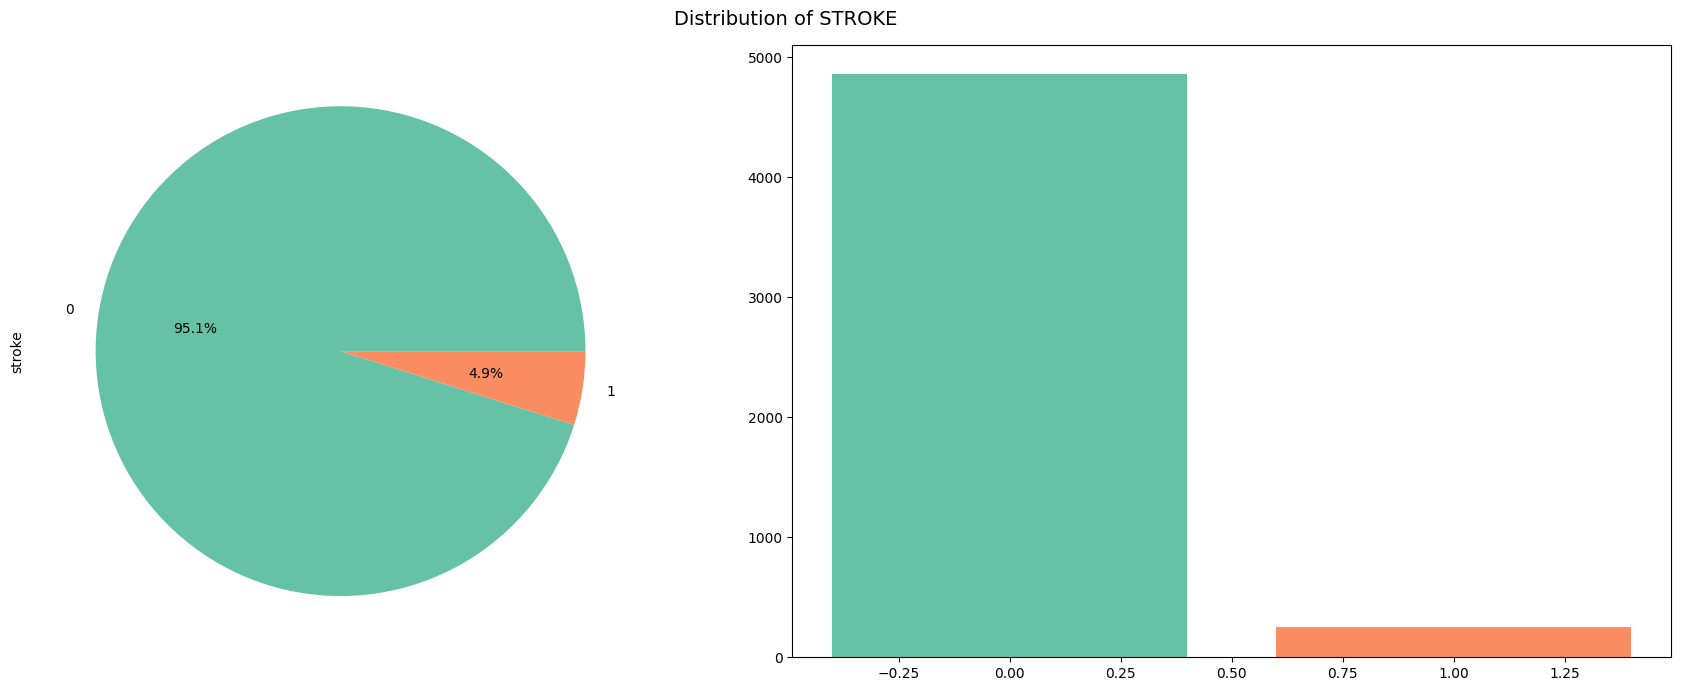

In [689]:
''' Plotting distribution of stroke '''
helper_functions.plot_pie_and_bar(df, "stroke")

#### Numerical Values Distribution - Age, BMI, Average Glucose Level

After cleaning the dataset, I wanted to see the distribution of numerical values.

* **Age**
    * Mean age value is 43.3
    * Median age is 45
    * 25% of the entries have age 25 or below
    * 50% of the entries have age 45 or below
    * 75% of the entries have age 61 or below
        * min age - 0.08
        * max age - 82
        
* **BMI**
    * Mean bmi is 28.8
    * Median bmi is 27.9
    * 25% of the entries have bmi 23.6 or below
    * 50% of the entries have bmi 27.9 or below
    * 75% of the entries have bmi 32.8 or below
        * min bmi - 10.3
        * max bmi - 97.6

* **Average Glucose Level**
    * Mean average glucose level is 106.14
    * Median average glucose level is 91.88
    * 25% of the entries have average glucose level 77.2 or below
    * 50% of the entries have average glucose level 91.8 or below
    * 75% of the entries have average glucose level 114.0 or below
        * min avg_glucose_level - 55.12
        * max avg_glucose_level - 271.74

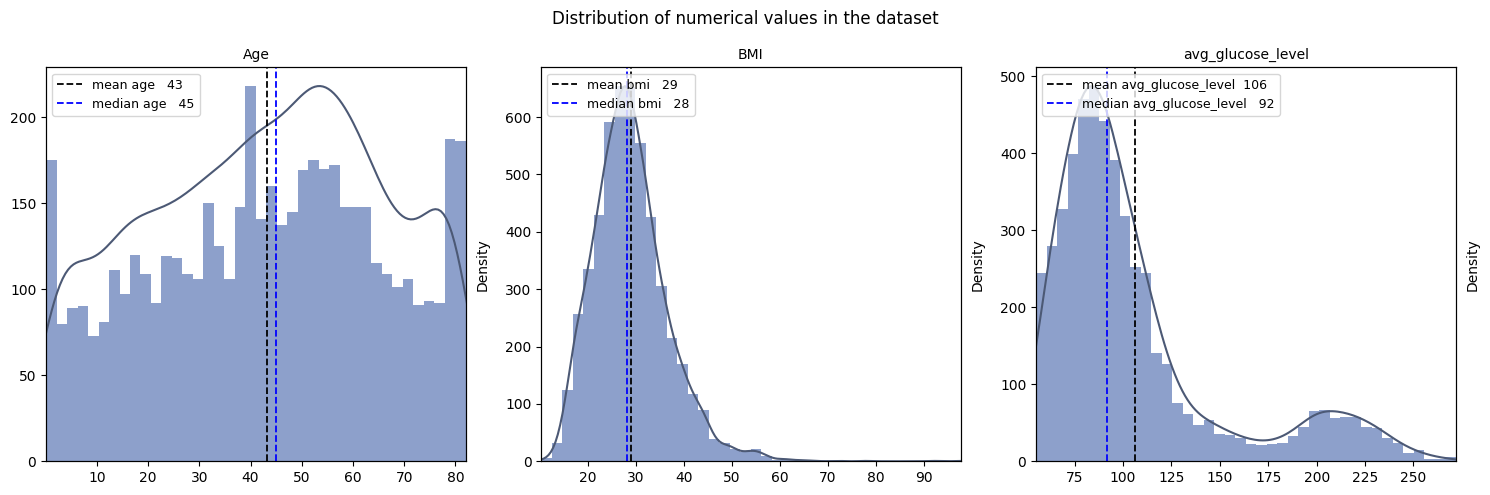

In [690]:
''' Plotting histograms for numerical values '''
helper_functions.plot_numerical_histograms(df)

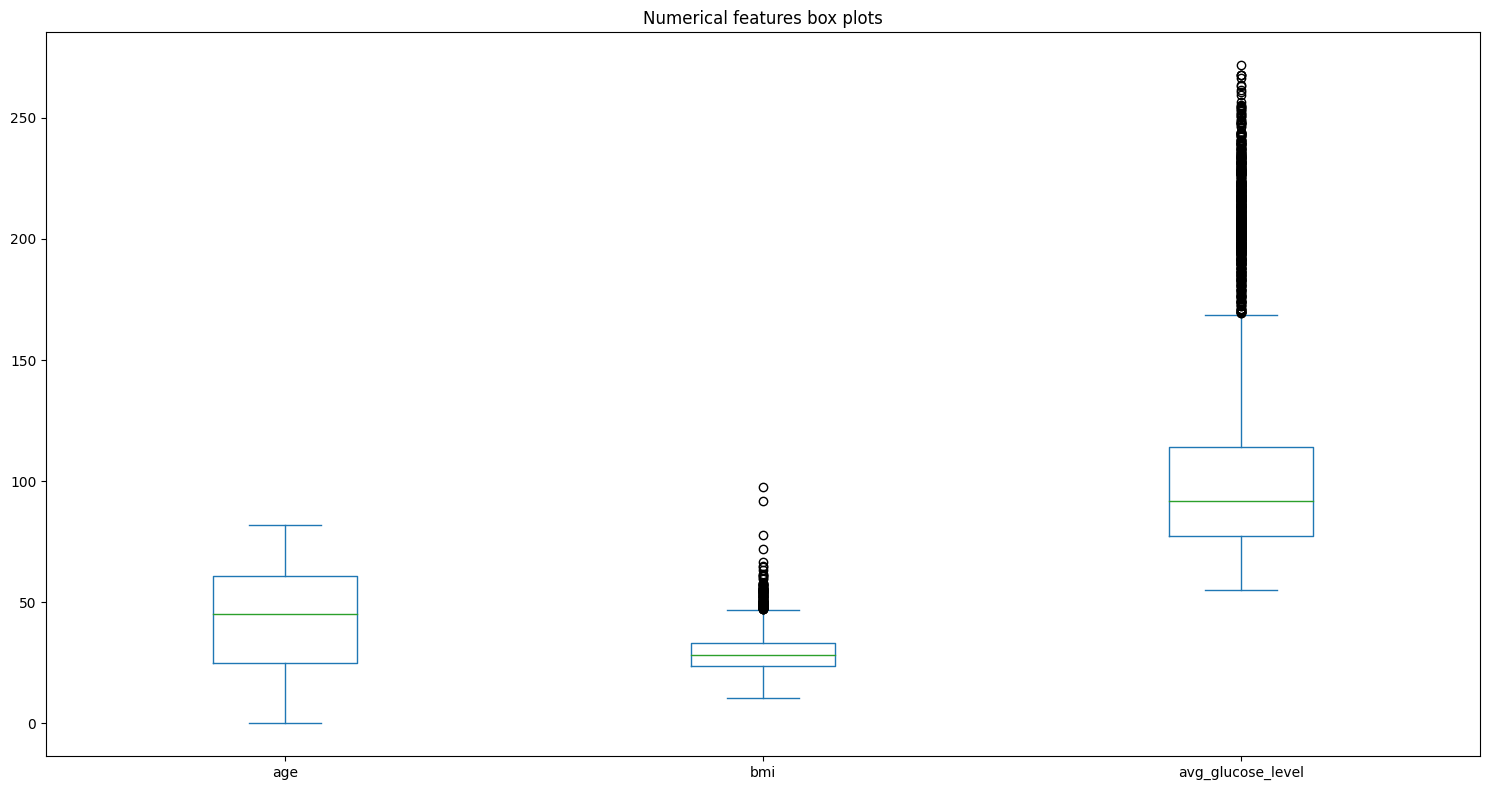

In [691]:
''' Plotting numerical values box plots '''
helper_functions.plot_numeric_values_box_plots(df)

#### Age Differences - people with/without stroke

The risk of having a stroke increases with age. This is due to a number of factors, including an increased risk of hypertension, heart disease, and other health problems that are more common in older people.

I wanted to see the age differences between people who have stroke and who did not in the dataset.

People who **had** stroke:
* Mean age - 67.72
* Median age - 71.0
* Min age - 1.32
* Max age - 82 
* 25% of the entries had age 59 or below
* 50% of the entries had age 71 or below
* 75% of the entries had age 78 or below


People who **did not have** stroke:
* Mean age - 41.9
* Median age - 43.0
* Min age - 0.08
* Max age - 82 
* 25% of the entries had age 24 or below
* 50% of the entries had age 43 or below
* 75% of the entries had age 59 or below

Thus, we can conclude that, in general, people who did not have stroke were younger than people who did.

These results can be seen in a kde plot below.

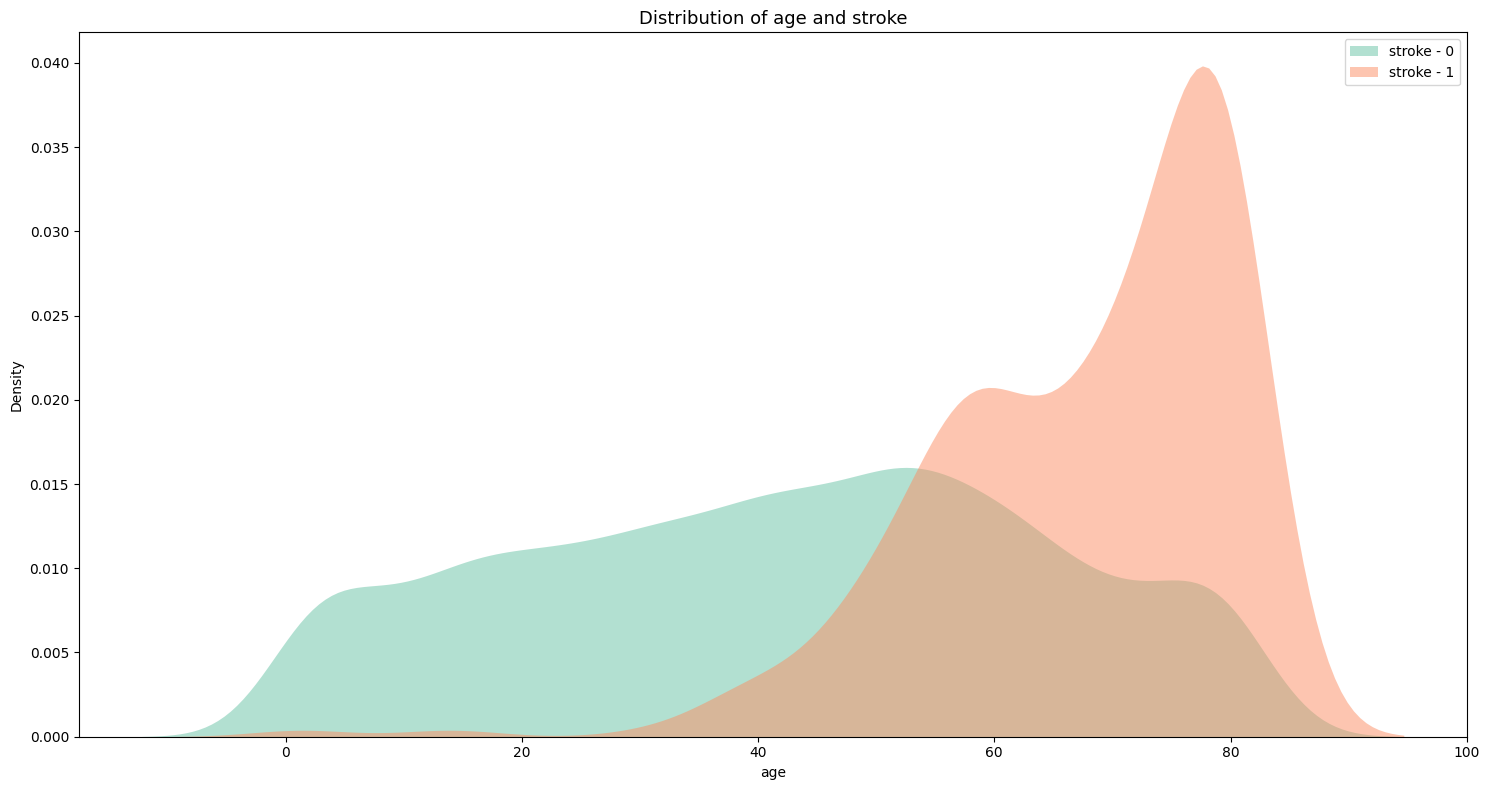

In [692]:
""" Plotting kde for age and different stroke values """
helper_functions.plot_two_kde(df, "age", "stroke")

We can see similar results in a box plot as well which shows differences by gender. Overall, both men and women are at risk of having a stroke, and it is important for both sexes to be aware of the risk factors and to take steps to reduce their risks and age is one of the factors which increases chance of getting stroke.

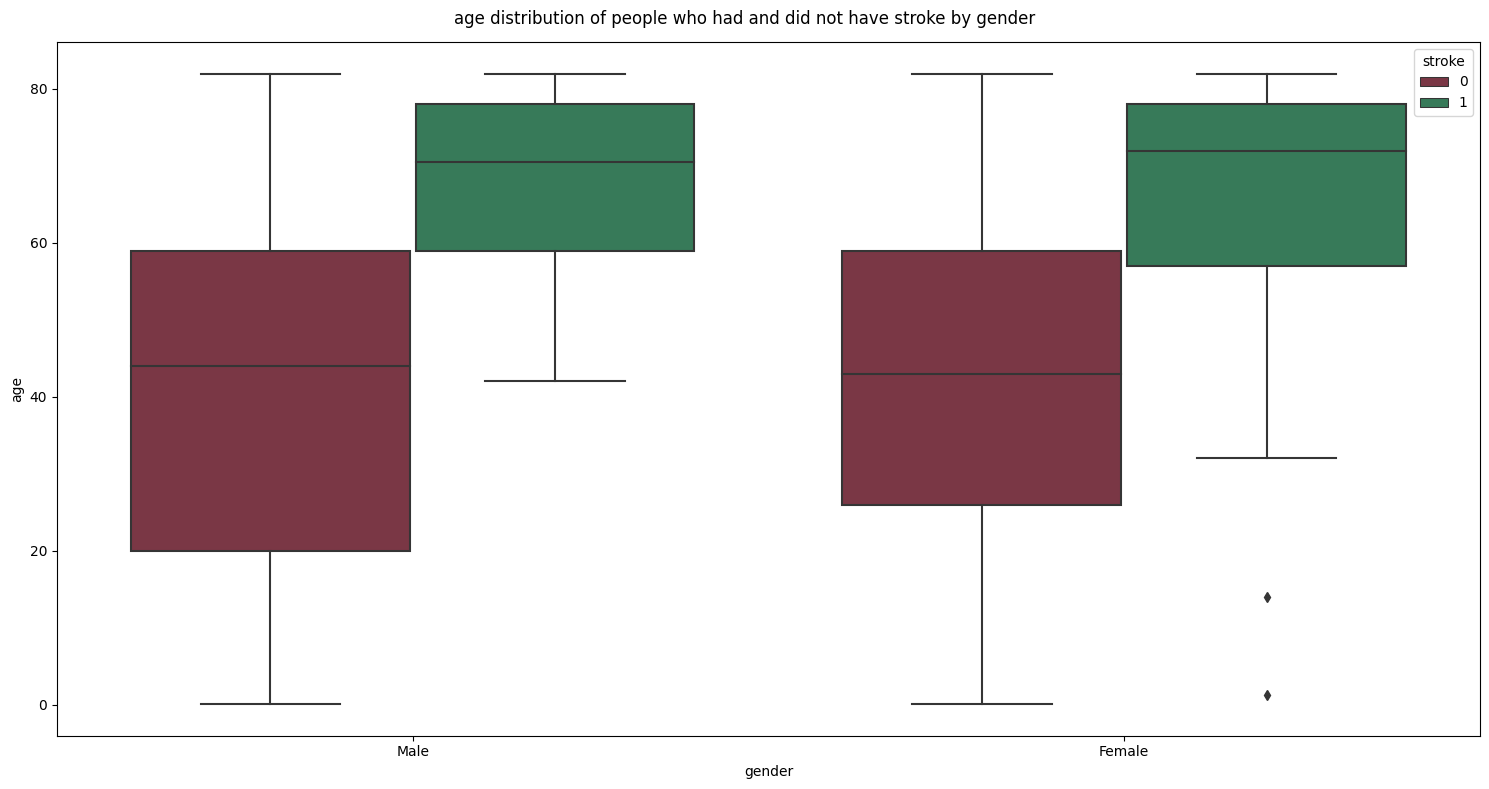

In [693]:
""" Age distribution by gender and stroke class """
helper_functions.plot_box_plot_by_col(df, "age")

#### BMI Differences - people with/without stroke

In general, body mass index (BMI) is a factor that can affect the risk of stroke. BMI is a measure of body fat based on height and weight and is used to classify individuals as underweight, normal weight, overweight, or obese. Individuals with a high BMI (overweight or obese) are at a higher risk of developing stroke compared to those with a normal BMI. This is because obesity is associated with several other risk factors for stroke, including high blood pressure, type 2 diabetes, heart disease, and high cholesterol.

I wanted to see whether we can see similar patterns in this dataset as well:

People who **had** stroke:
* Mean bmi - 30
* Min bmi - 16.9
* Max bmi - 56.6 
* Median bmi - 28.4
* 25% of the entries had bmi 26.9 or below
* 50% of the entries had bmi 28.4 or below
* 75% of the entries had bmi 32.5 or below


People who **did not have** stroke:
* Mean bmi - 28.7
* Min bmi - 10.3
* Median bmi - 27.8
* Max bmi - 97.6 
* 25% of the entries had bmi 23.5 or below
* 50% of the entries had bmi 27.8 or below
* 75% of the entries had bmi 32.8 or below

We can see that the bmi value does not differ much for people who had stroke.

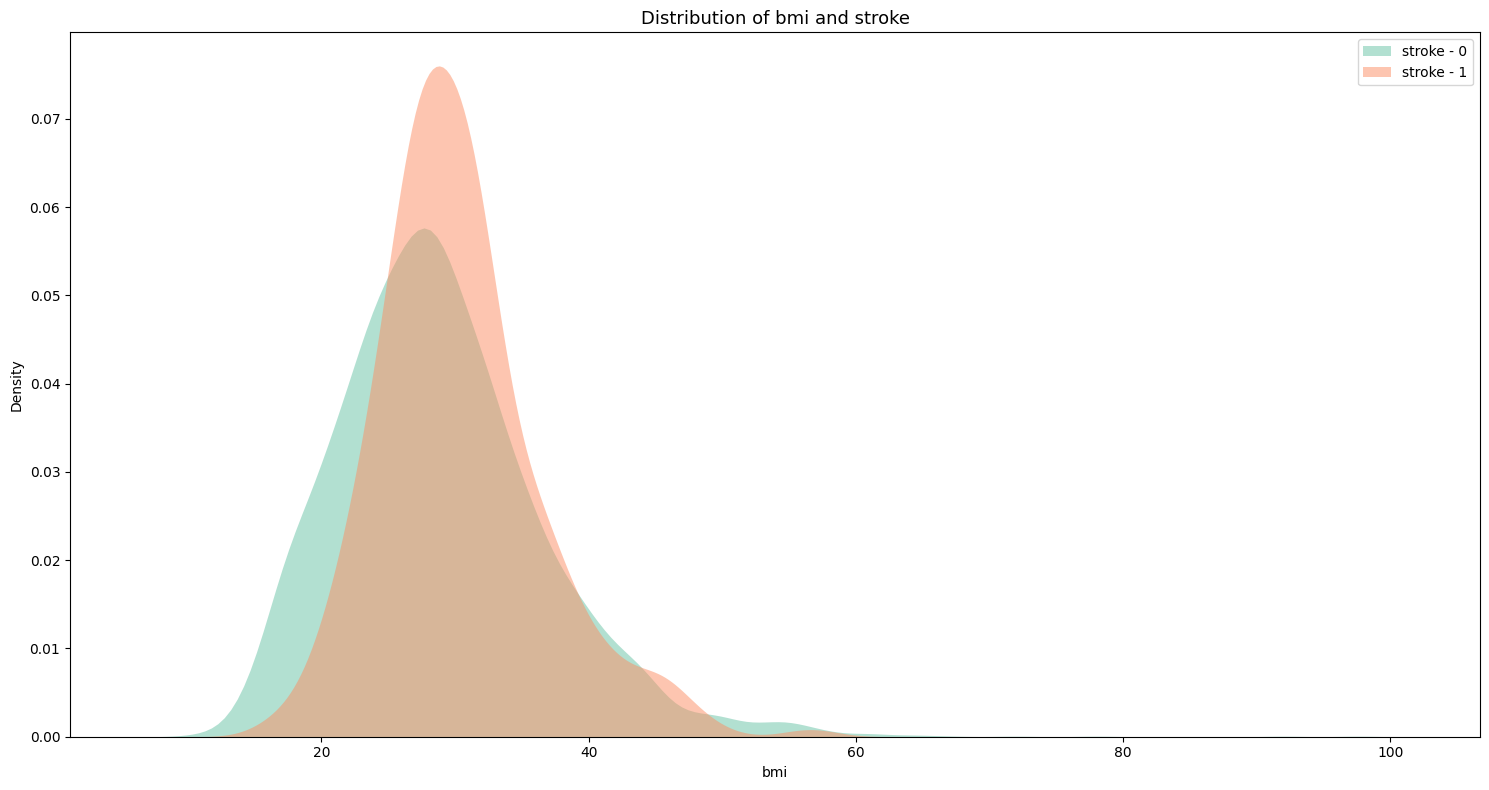

In [694]:
""" Plotting kde for bmi and different stroke values """
helper_functions.plot_two_kde(df, "bmi", "stroke")

We can see that the distributions are similar for both people groups by gender.

On average, women tend to have a higher body mass index (BMI) than men. However, this can vary depending on factors such as age, ethnicity, and overall health status.

In general, women tend to have more body fat than men, and this can contribute to a higher average BMI. Women also have a higher amount of body fat in certain areas, such as the hips and thighs, which can increase their overall BMI.

However, this is not true for all women and many factors can influence BMI, including genetics, lifestyle, and health status. Some women may have a lower BMI due to factors such as a lower muscle mass, a smaller body frame, or a more active lifestyle.

In this particular dataset, we can also see that the differences are not major for these two genders.

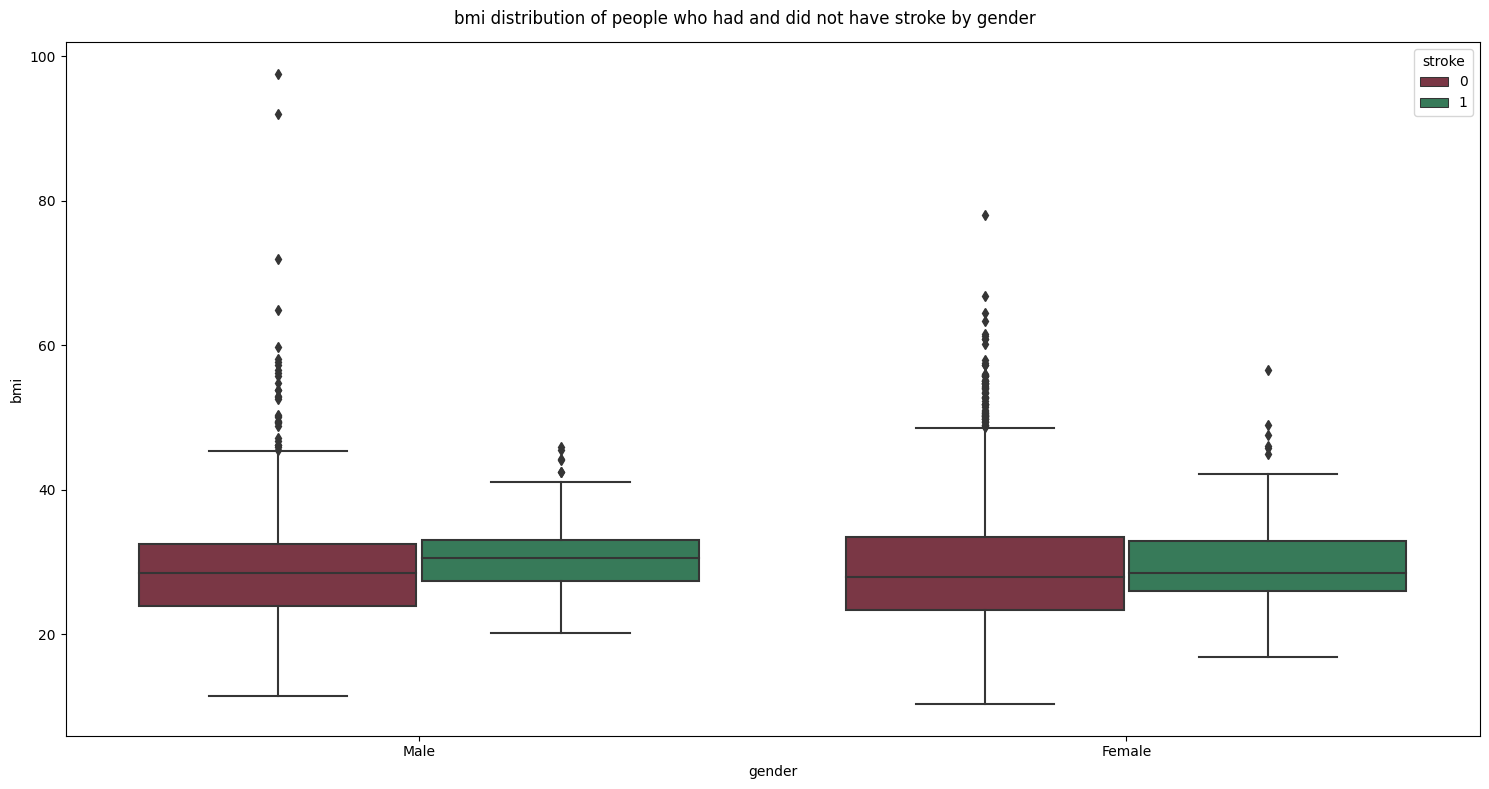

In [695]:
""" BMI distribution by gender and stroke class """
helper_functions.plot_box_plot_by_col(df, "bmi")

#### Average Glucose Level Differences - people with/without stroke
Lastly, I wanted to see the same for the last numerical continuous variable - average glucose level. Average glucose level, also known as average blood sugar level, is an important factor for stroke risk. High blood sugar levels, or hyperglycemia, can increase the risk of stroke and other health problems.

We can see two spikes for both of the groups
* Where avg_glucose_level is around 80-90
* Where avg_glucose_level is around 210-220

People who **had** stroke:
* Mean avg_glucose_level - 132.5
* Median avg_glucose_level - 105.22
* Min avg_glucose_level - 56.11
* Max avg_glucose_level - 271.74
* 25% of the entries had avg_glucose_level 79.79 or below
* 50% of the entries had avg_glucose_level 105.22 or below
* 75% of the entries had avg_glucose_level 196.71 or below


People who **did not have** stroke:
* Mean avg_glucose_level - 104.78
* Median avg_glucose_level - 91.465
* Min avg_glucose_level - 55.12
* Max avg_glucose_level - 267.76
* 25% of the entries had avg_glucose_level 77.12 or below
* 50% of the entries had avg_glucose_level 91.46 or below
* 75% of the entries had avg_glucose_level 112.8 or below

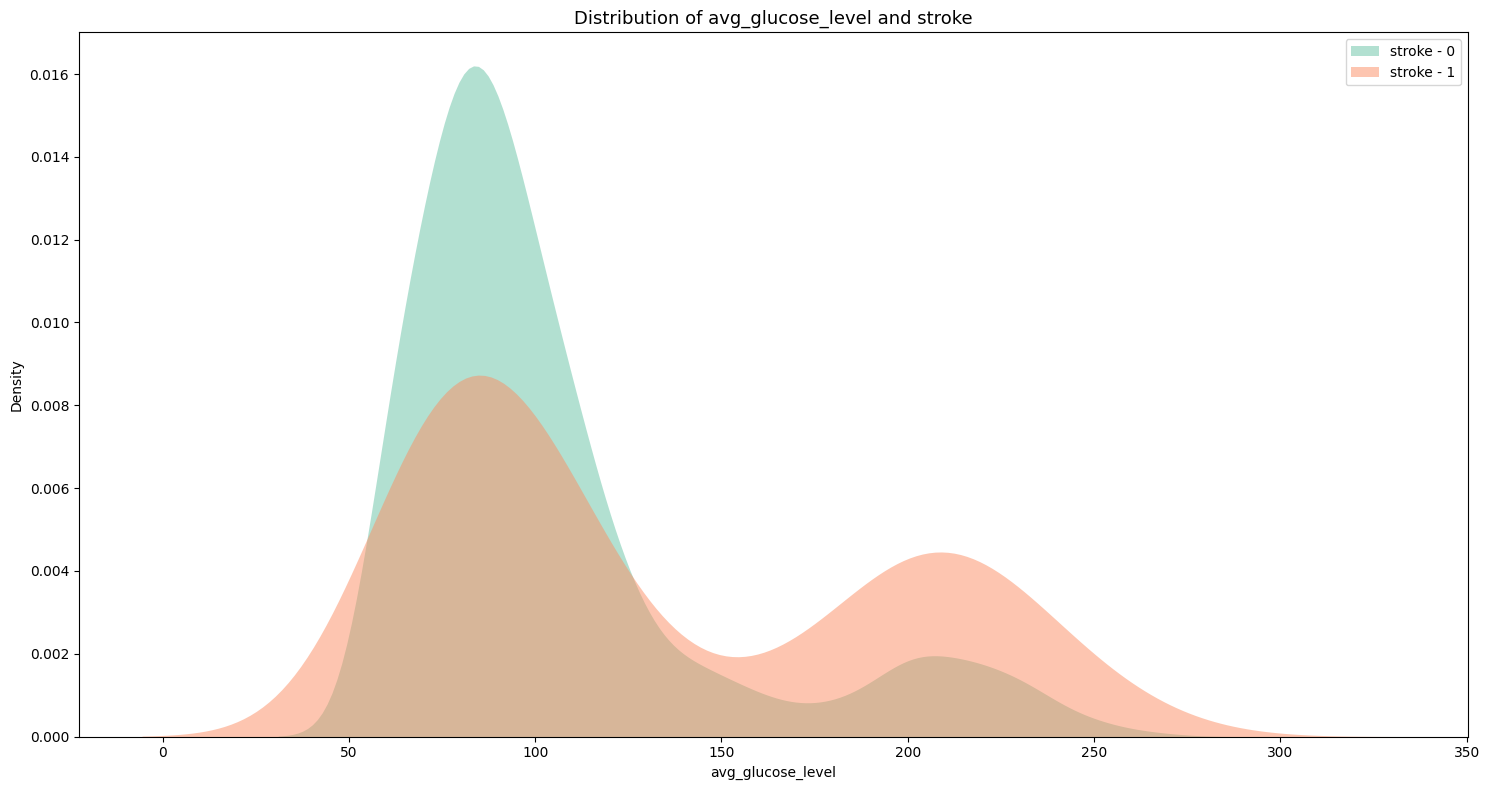

In [696]:
""" Plotting kde for avg_glucose_level and different stroke values """
helper_functions.plot_two_kde(df, "avg_glucose_level", "stroke")

On average glucose levels are higher for people who had stroke. We can see a higher spike compared to people who did not have stroke on the higher end of the kde plot where avg_glucose_level is around 210-220.

Median for people who had stroke is also higher. Male had higher avg_glucose_level compared to women.

But in general, there is no inherent difference in glucose levels based on gender, as both men and women can have normal or abnormal glucose levels. However, various factors such as age, body composition, diet, physical activity, and overall health can influence an individual's glucose levels, regardless of gender.

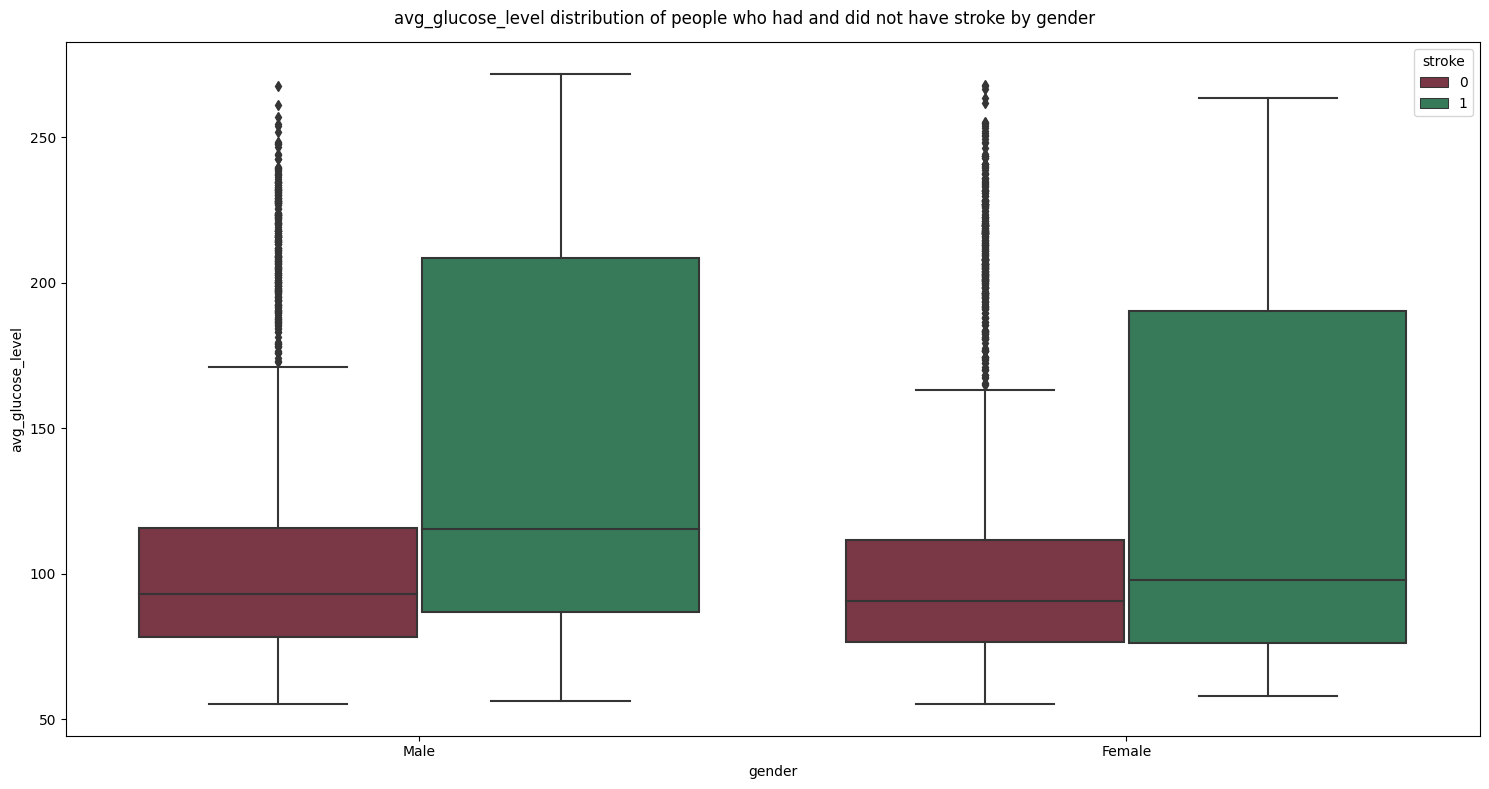

In [697]:
""" Avg glucose level distribution by gender and stroke class """
helper_functions.plot_box_plot_by_col(df, "avg_glucose_level")

#### Marriage Status

I wanted to see whether these is a connection between having stroke and marriage status. 

Marriage may be associated with a reduced risk of stroke. This is thought to be due to the support and assistance that a spouse can provide, such as helping with activities of daily living, managing medication, and providing emotional support.

On the other hand, other studies have suggested that being married may be associated with an increased risk of stroke, potentially due to stress from relationship conflicts or differences in lifestyle habits between partners.

This dataset also contains "ever_married" feature which has values - Yes or No

We can see that this dataset contains more people who were married. 65.6% of people answered "Yes" and 34.4% - "No"

I also wanted to see whether there are some correlations with marriage status and stroke. We can see that 6.6% of married people had stroke, where only 1.7% of people did not. This of course can be influenced by imbalanced data as we have far more entries of married people. 

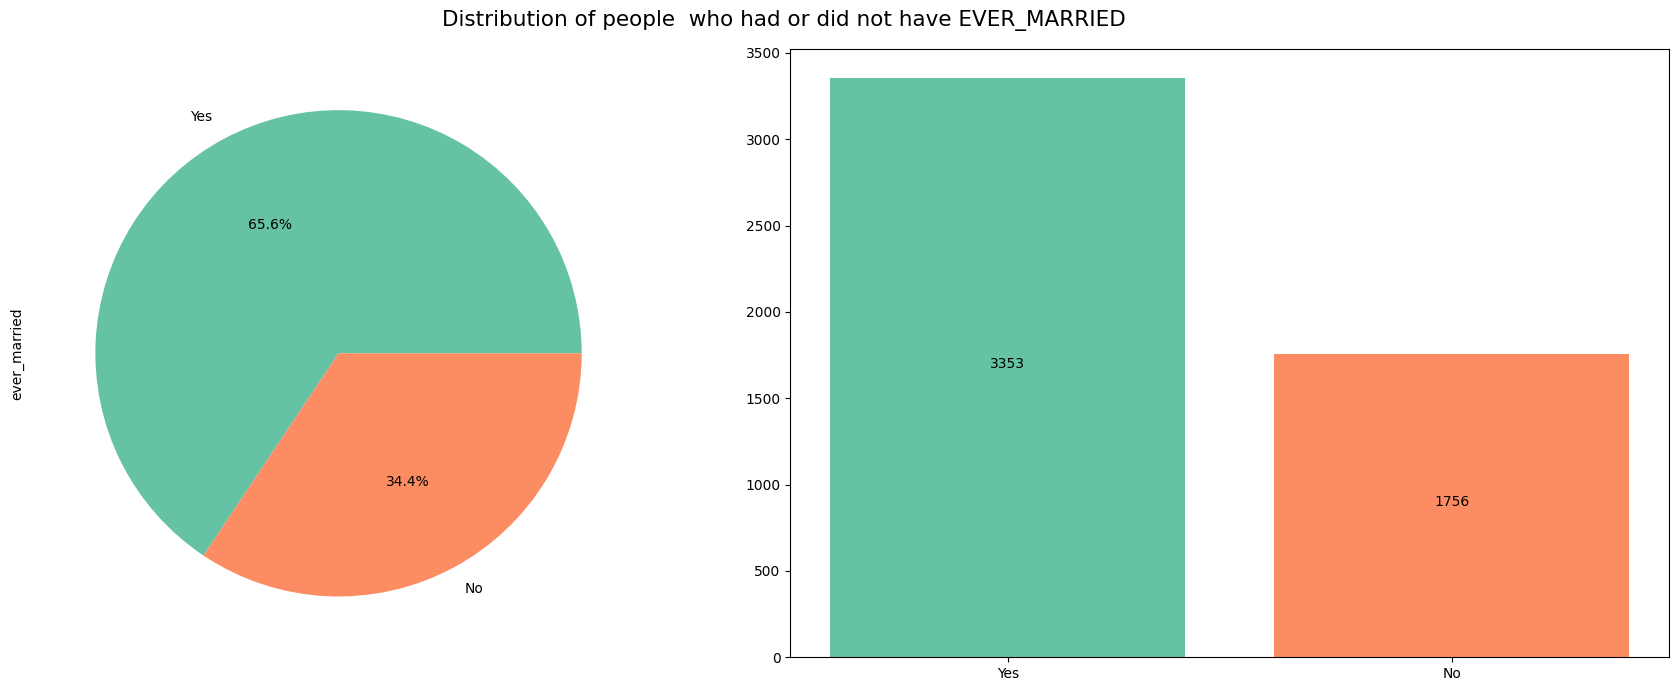

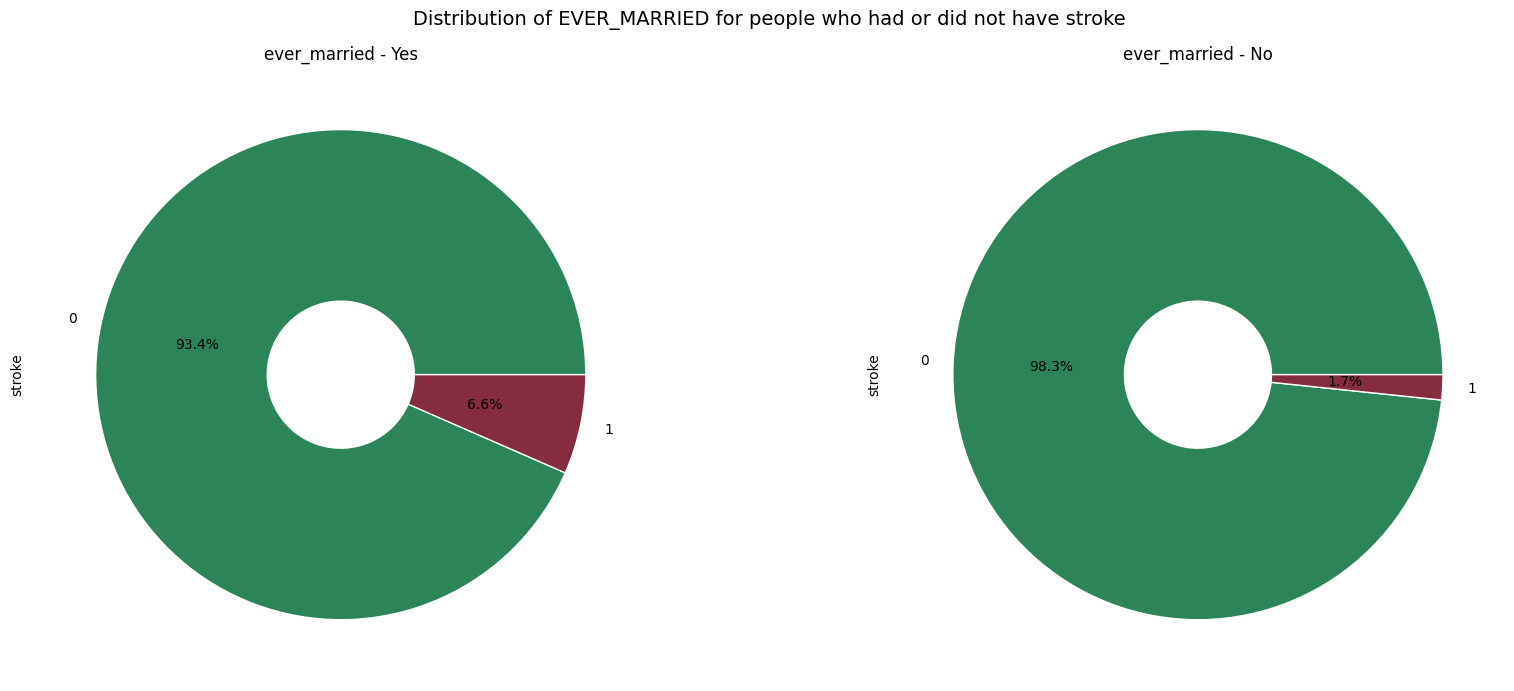

In [698]:
""" Plot ever_married distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "ever_married")

I wanted also investigate how age differs in married people. Naturally, young people tend to be not married yet in their life (due to them being children or just too young), thus we can see different distributions for these two groups.

Married People:
* Mean age - 54.34
* Median - 54
* Min - 18
* Max - 82

Not Married People:
* Mean age - 22
* Median - 18
* Min - 0.08
* Max - 82

Therefore, we can say that the previous investigation of ever_married column might be impacted by the age of people who were married as younger people are less likely to be married.

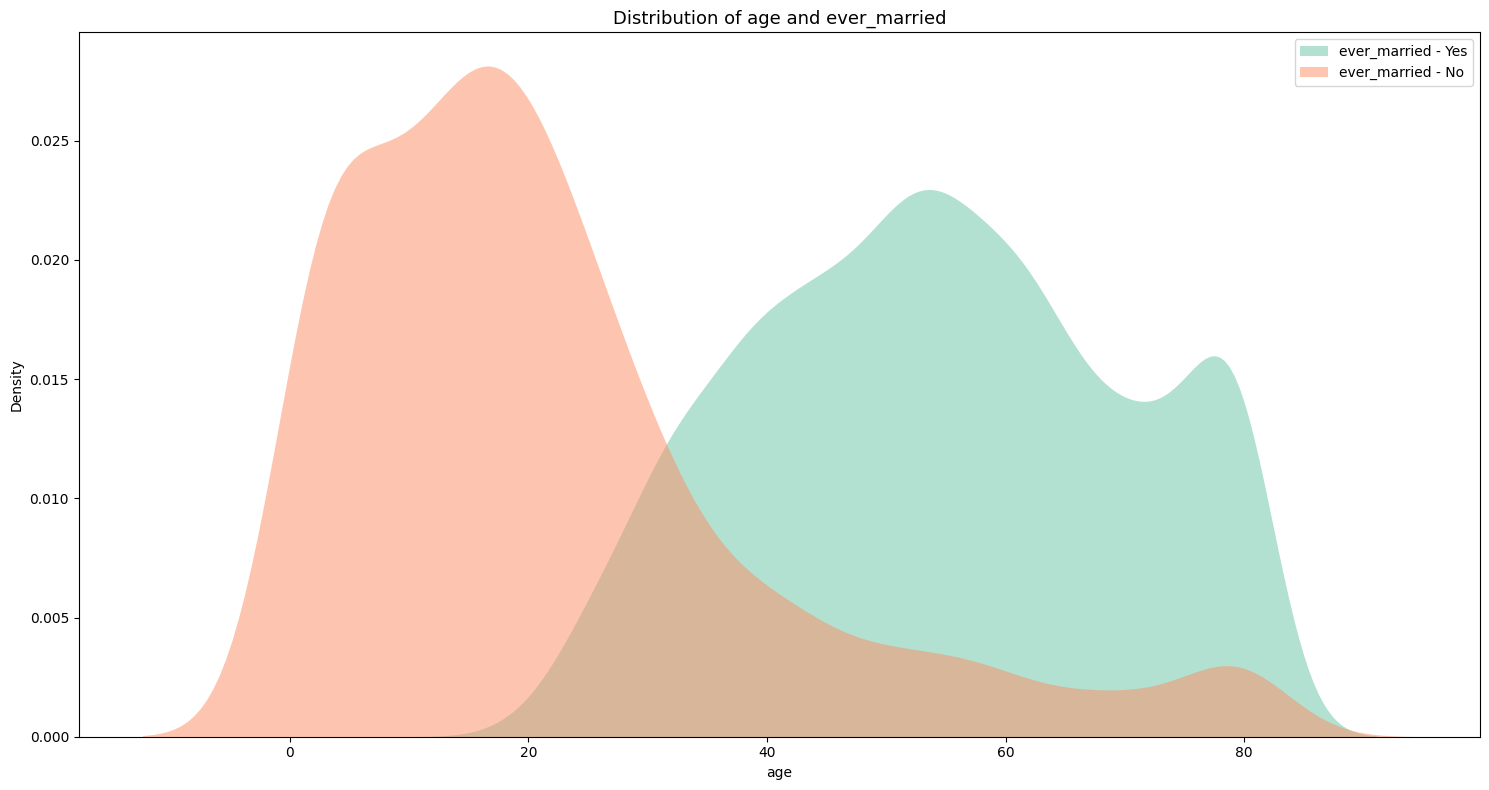

In [699]:
""" Plot age distribution by ever_married """
helper_functions.plot_two_kde(df, "age", "ever_married")

#### Recidence Type

This dataset also contains "Residence_type" feature which has values - Urban or Rural

Urban and rural living environments can impact the risk of stroke, as they can differ in terms of access to healthcare, availability of healthy food options, and opportunities for physical activity. For example, urban areas may have more access to specialized medical care and rehabilitation resources, which can improve outcomes for people who experience a stroke. On the other hand, urban areas may also be associated with higher levels of air pollution, traffic, and stress, which can increase the risk of stroke, therefore, rural areas may also have a more favorable environment for physical activity and access to fresh, healthy food options and better mental health.

We have 50.8% of people who live in Urban area and 49.2% who live in Rural. This feature is important because residency area might have impact on our lungs as air in rural areas is cleaner due to nature and less traffic.

I also wanted to see whether there is some differences in "stroke" column. We can see that 5.2% of people who live in urban areas had stroke and 4.5% of people who live in rural area.

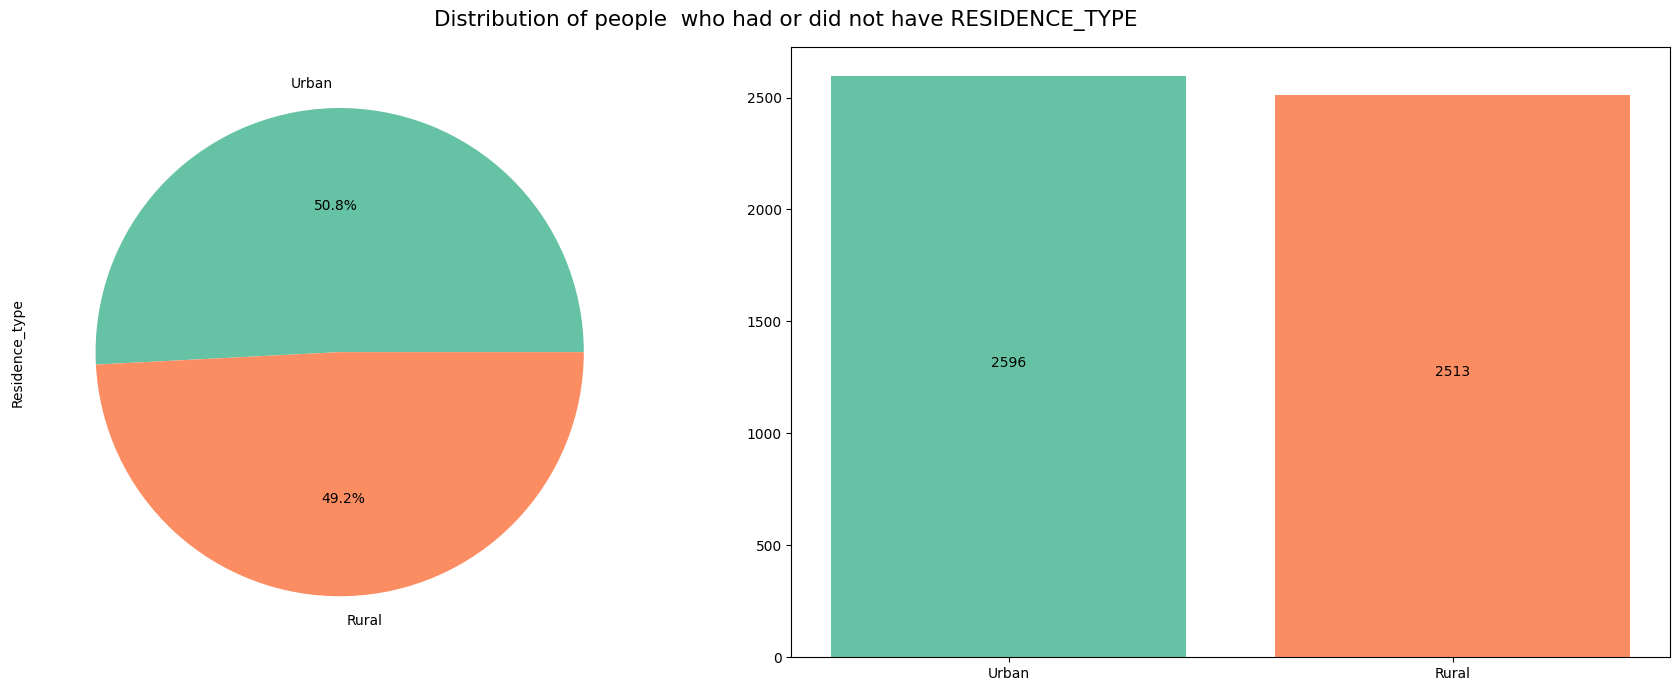

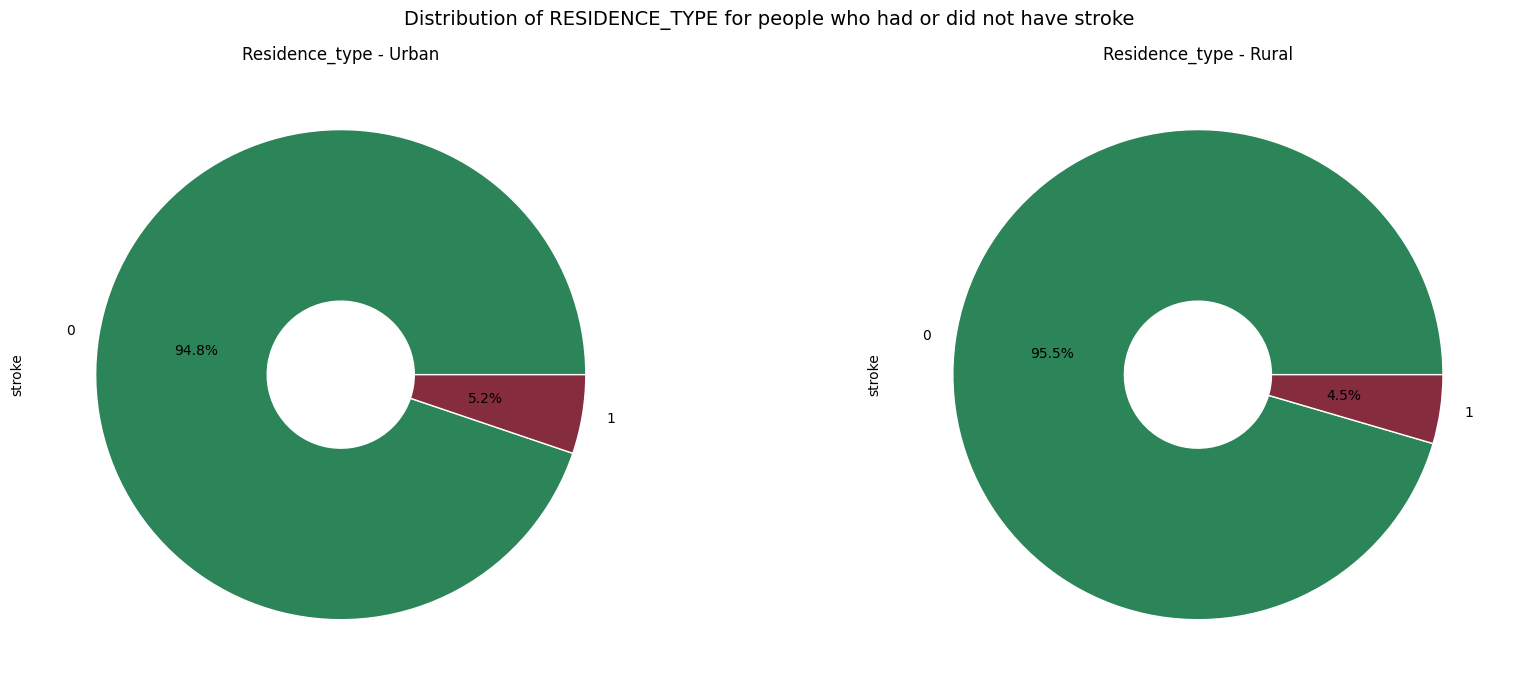

In [700]:
""" Plot Residence_type distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "Residence_type")

As age seems to play important role in stroke feature, I wanted to see the difference between age of people who live in rural or urban areas. But the age distribution of these two groups seems to be similar.

People in **Urban** area:
* Mean age - 43.5
* Min age - 0.08 
* Max - 82
* Median - 45

People in **Urban** area:
* Mean age - 42.9
* Min age - 0.08 
* Max - 82
* Median - 44

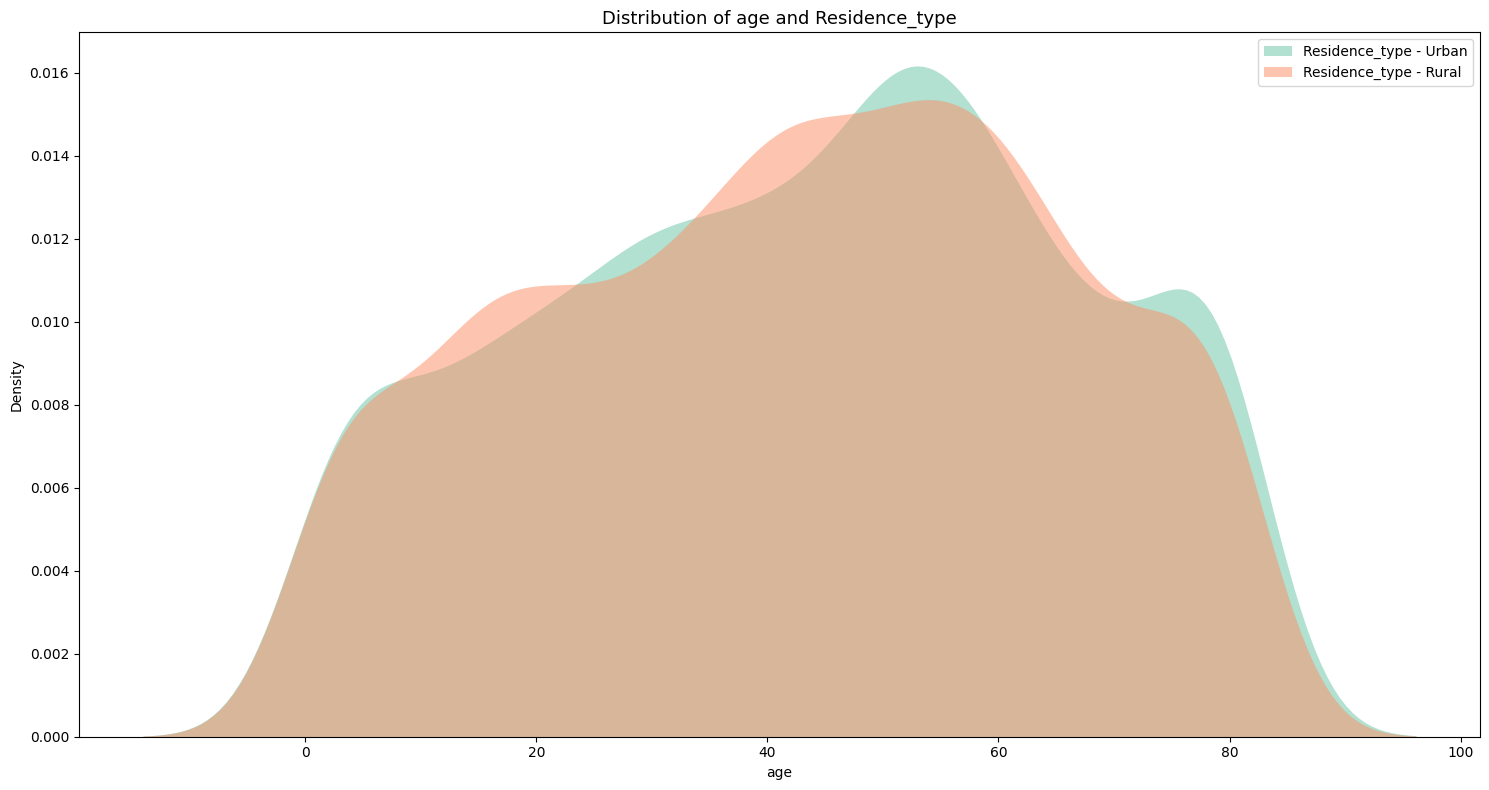

In [701]:
""" Plot age distribution by Residence_type """
helper_functions.plot_two_kde(df, "age", "Residence_type")

#### Smoking status

Smoking increases risk of stroke by increasing blood pressure and reducing oxygen in the blood. Therefore, this feature should be important for stroke prediction. Smoking can cause damage to the blood vessels and increase the risk of several conditions that are associated with stroke, such as high blood pressure. In addition, smoking can increase the levels of carbon monoxide in the bloodstream, which decreases the amount of oxygen available to the brain and other organs.

* 46.3% of people **never smoked**
* 21% of data is **unknown**
* 17.3% of data is **formerly smoked**
* 15.4% of data is **smokes**

We don't see a large difference in stroke value for people who smokes. In fact, the largest percentage of people who had stroke had the group "formerly smoked".

In [702]:
""" Change smoking_status for children whose age is lower than 10 """
print(f"Children smoking_status values {df[df['age'] < 10]['smoking_status'].unique()}")
df.loc[df["age"] < 10, "smoking_status"] = "never smoked"

Children smoking_status values ['Unknown']


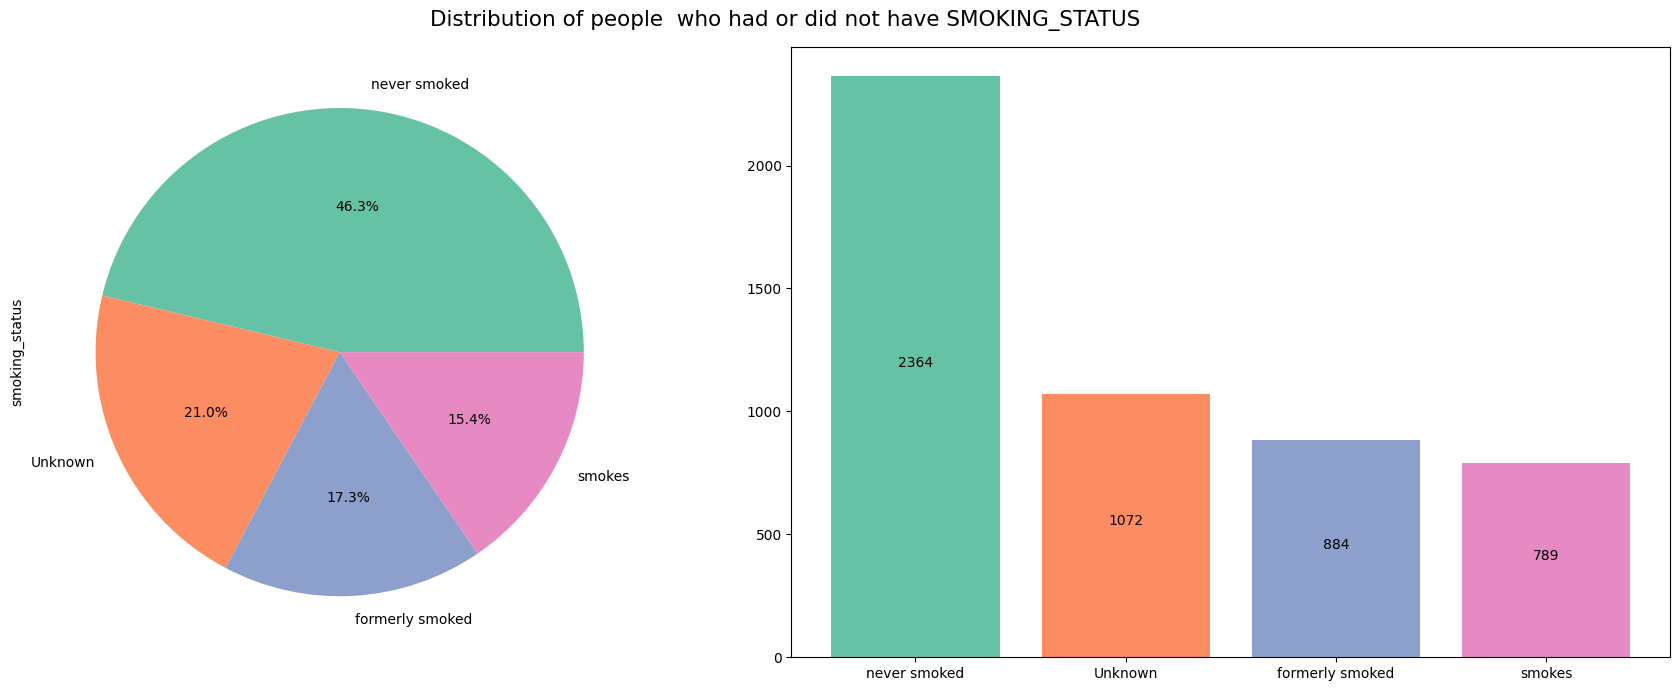

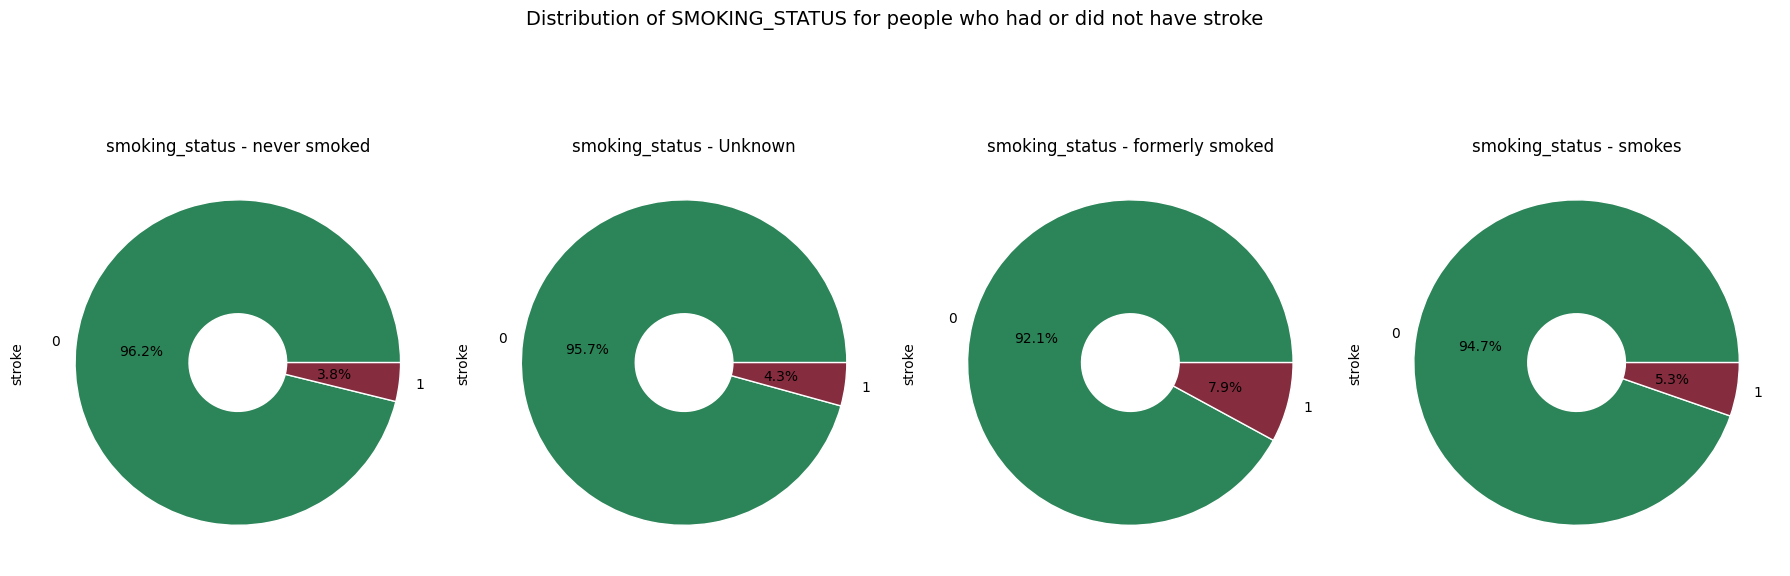

In [703]:
""" Plot smoking_status distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "smoking_status")

I wanted to see maybe these results might be impacted by age. And indeed, we can see that the distribution of formerly smoked people is more towards the end - meaning it has more people who are older. And therefore, the Unknown value has such a small percentage of people who had stroke as its age distrbition contains more young people.

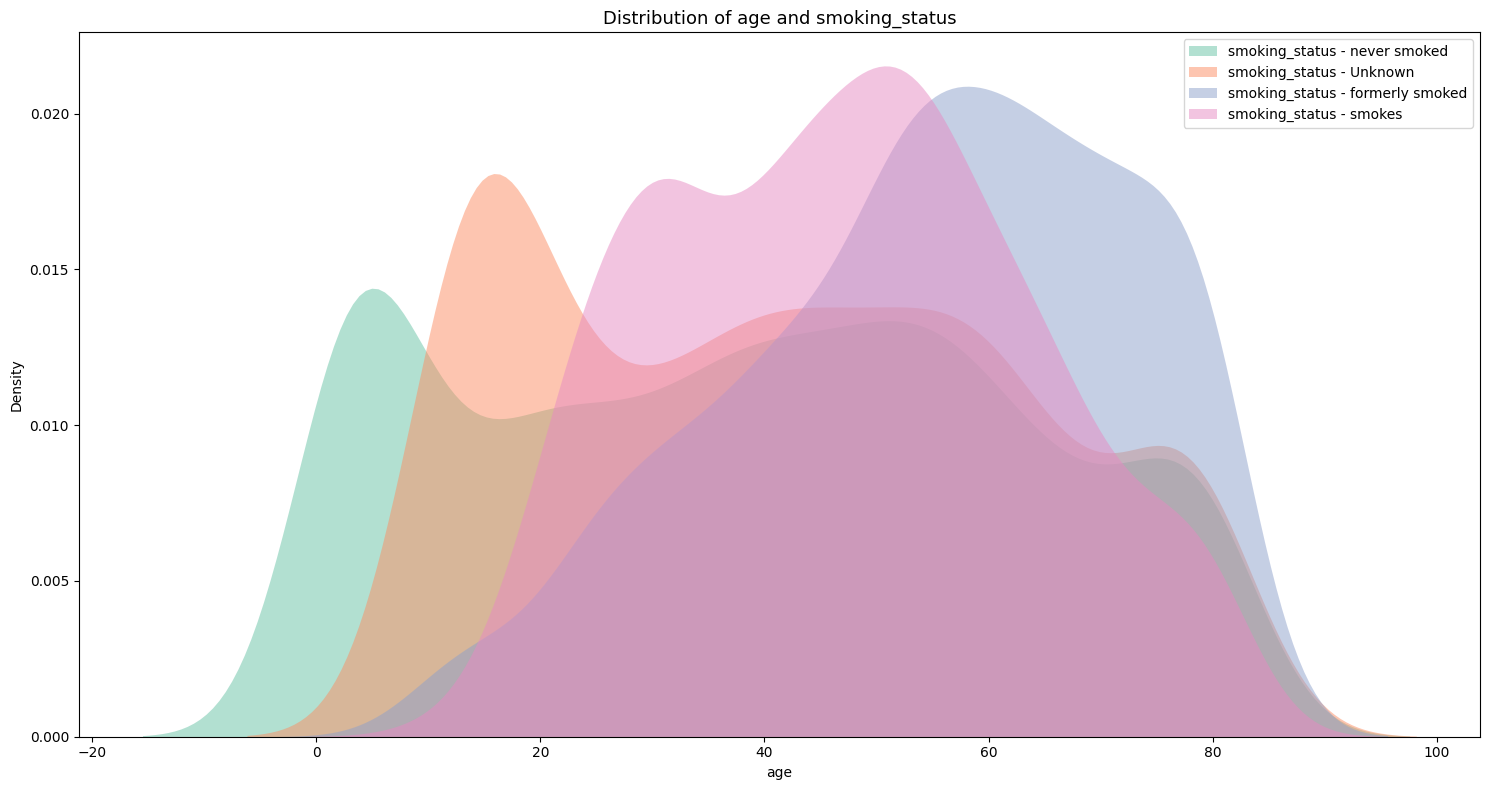

In [704]:
""" Plot age distribution by smoking_status """
helper_functions.plot_two_kde(df, "age", "smoking_status")

#### Work Type

We have five work types in the dataset - Private, Self-employed, children, Govt_job and Never Worked

Work type can be an important feature due to job-related stress, such as working long hours, tight deadlines, and high levels of job demands, may increase the risk of stroke by affecting cardiovascular health and the nervous system.

* 56.7% of people works in private sector
* 15.9% of people are self-employed
* 14.3% of people are children
* 12.8% of people works in government sector
* 0.3% of people never had worked

8% of people who are self-employed had stroke
5.1% of people who work in private sector had stroke
5.0% of people who work in government sector had stroke

In [705]:
""" Change working type for children whose age is lower than 15 """
df.loc[df["age"] < 15, "work_type"] = "children"

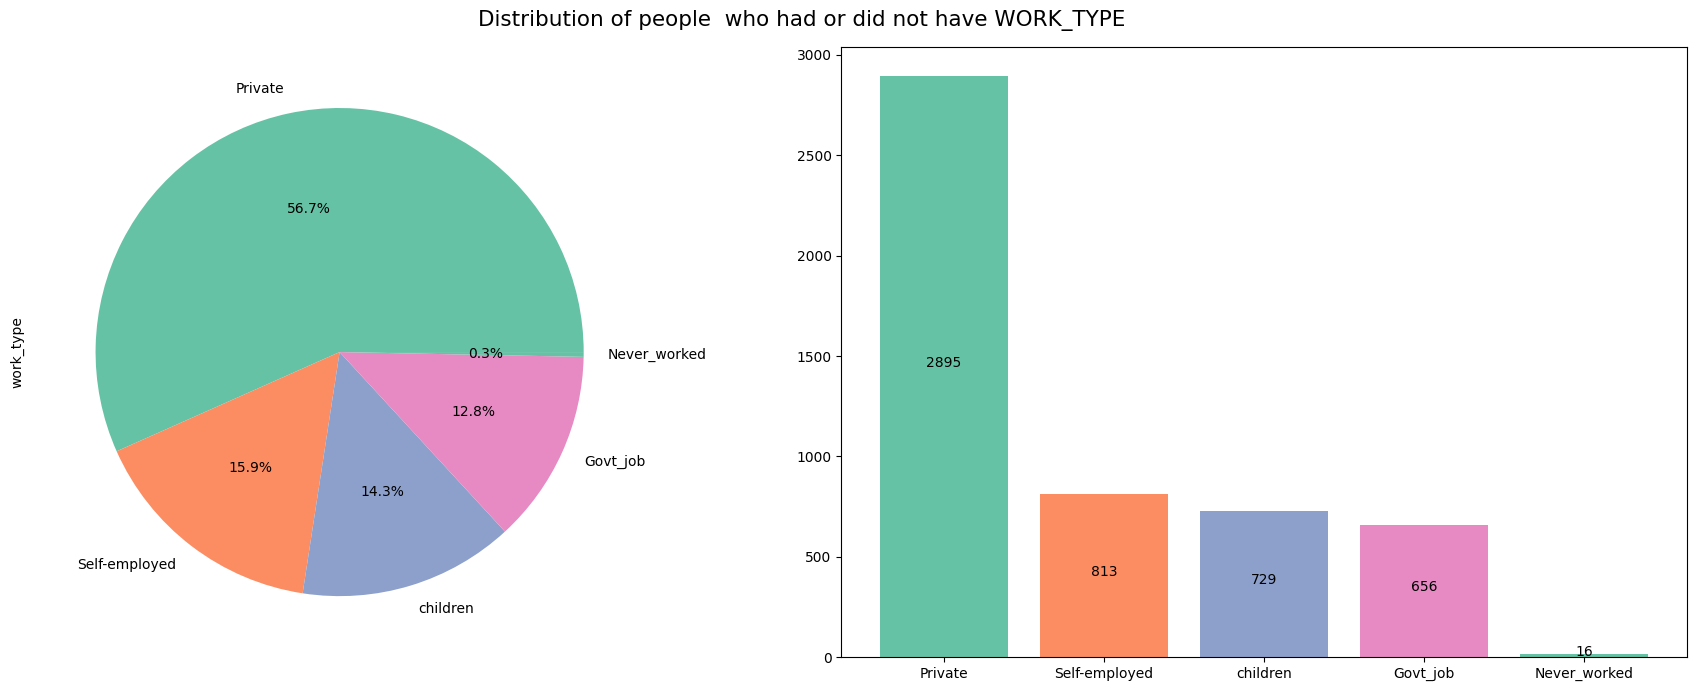

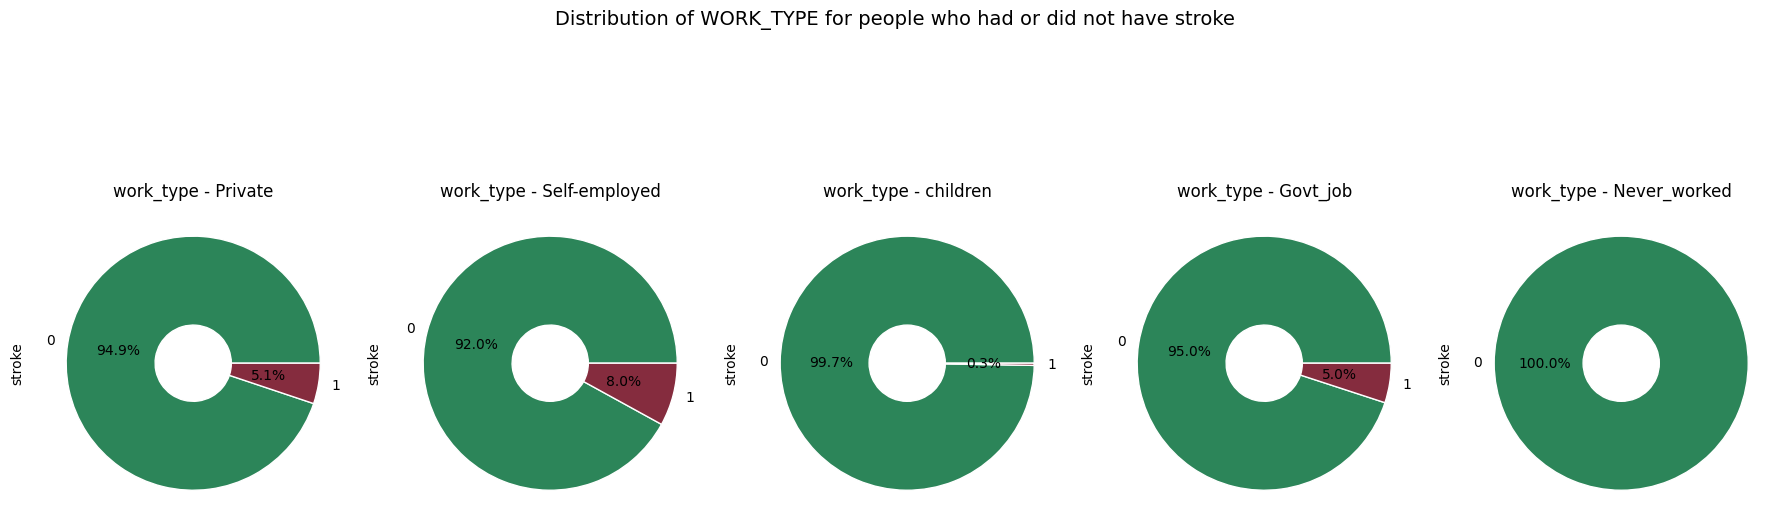

In [706]:
""" Plot work_type distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "work_type")

Once again, we can see that these results were also impacted by their age. Younger people are less likely to have job. We have a really small number of children who had stroke.

Median age of people who had stroke by work_type
* Private - 70.0
* Govt_job - 66.0
* Self-employed - 76.0
* children - 7.66 

Naturally, we can see that more older people are self-employed, thus, their percentage of people with stroke is larger.

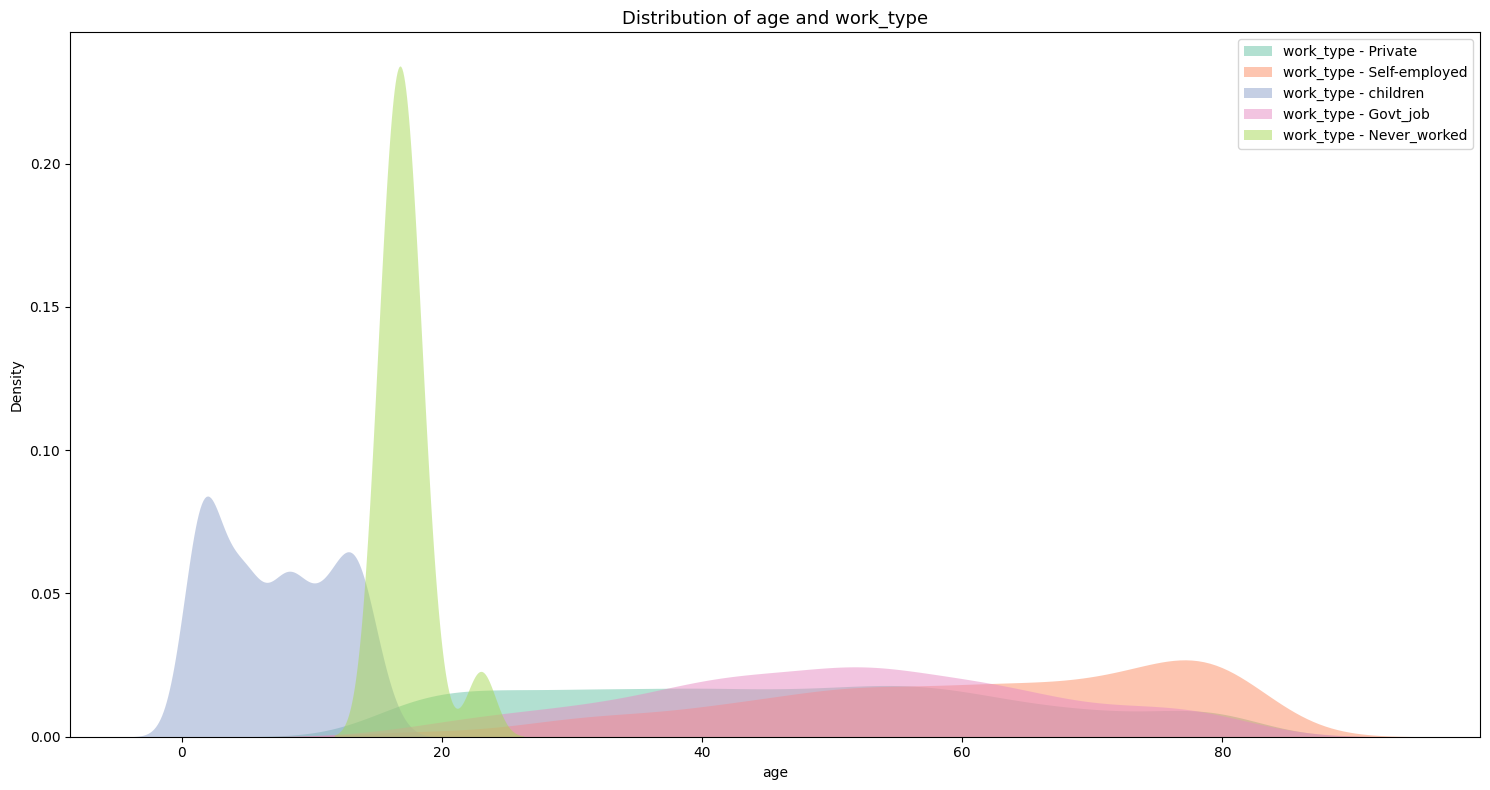

In [707]:
""" Plot age distribution by work_type """
helper_functions.plot_two_kde(df, "age", "work_type")

#### Hypertension

Hypertension is a major risk factor for stroke. High blood pressure can damage the blood vessels in the brain, leading to a stroke. In addition, high blood pressure can increase the risk of blood clots, which can cause a stroke by blocking blood flow to the brain.

In this particular dataset, 9.7% of people have hypertention and 90.3% do not. Out of all people with hypertention 13.3% of them also had stroke. And only 4% of people without hypertention had stroke.

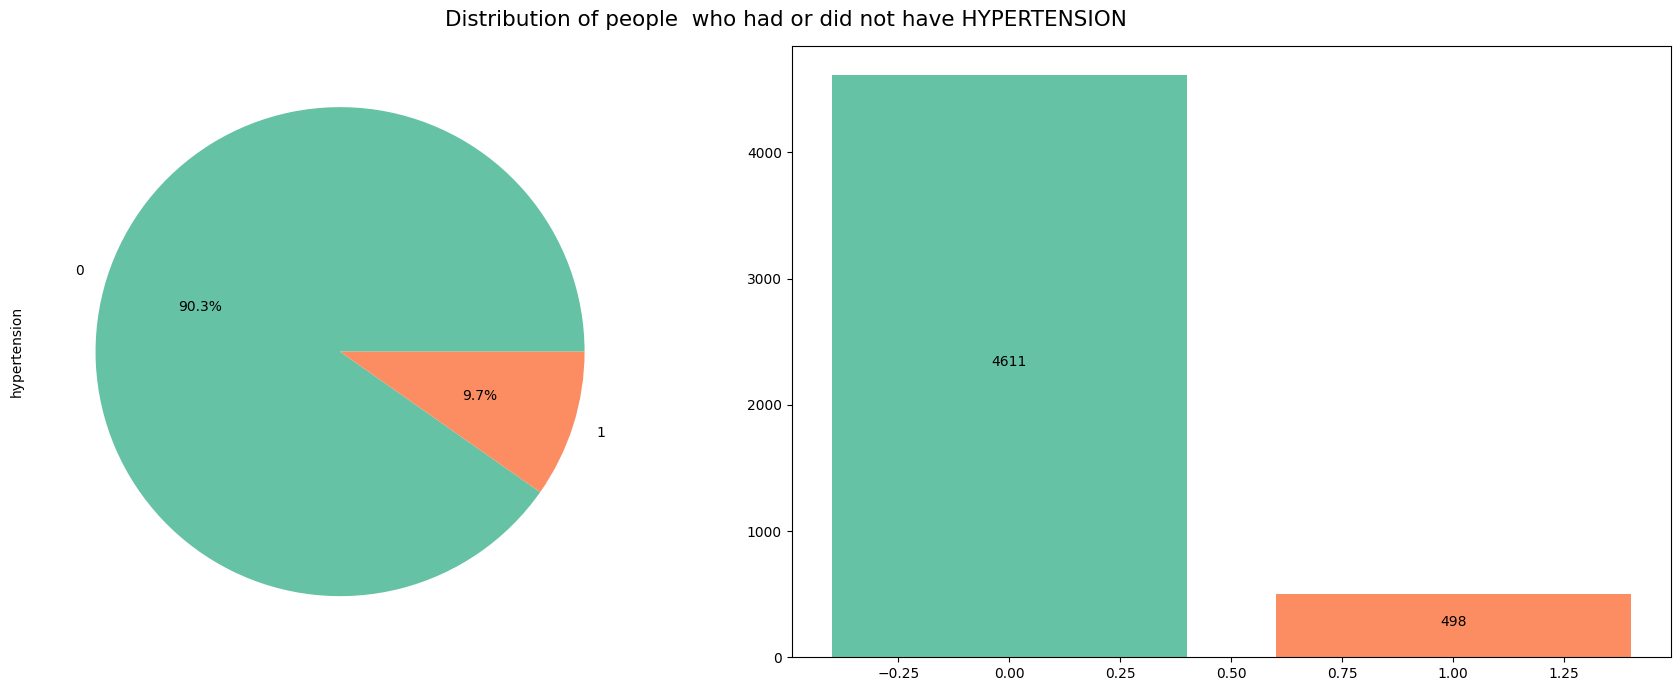

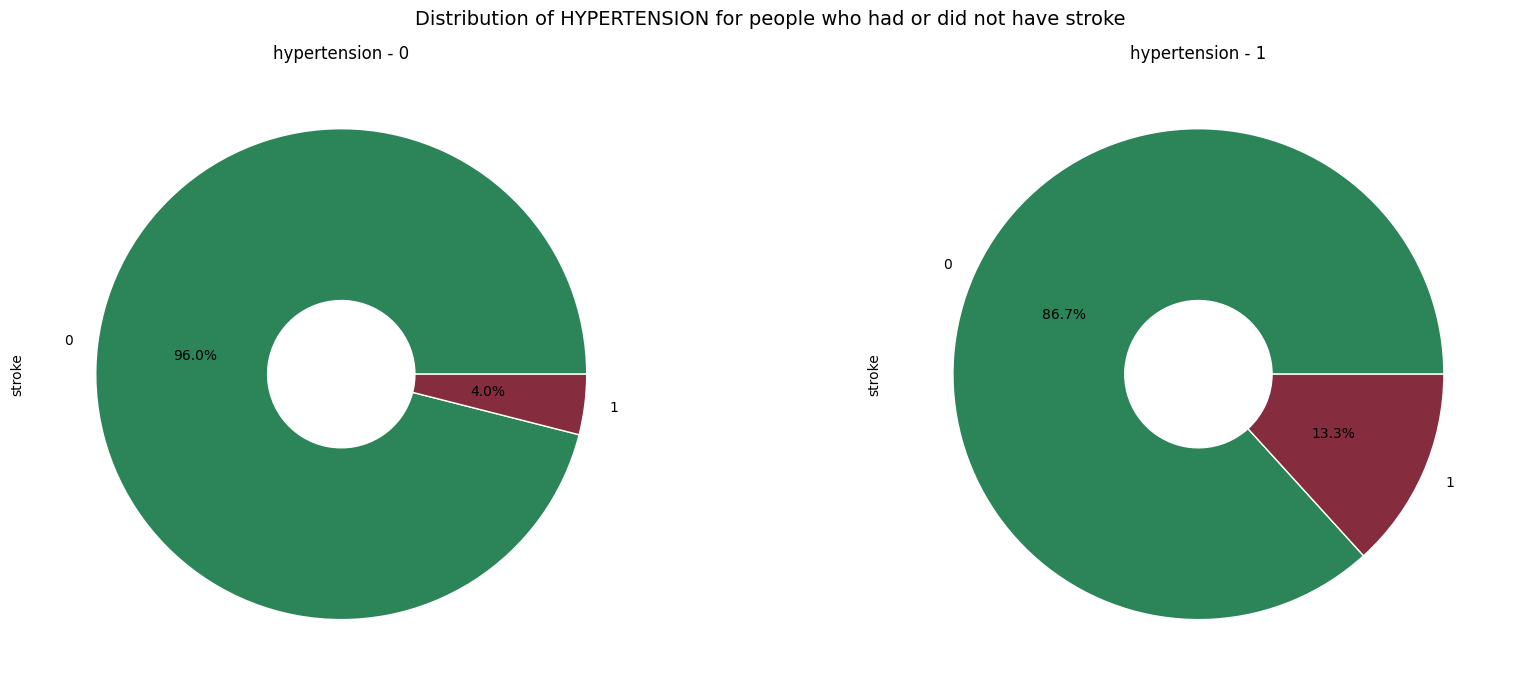

In [708]:
""" Plot work_type distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "hypertension")

#### Heart Disease

Heart disease can increase the risk of stroke. When the heart is not functioning properly, it can lead to the formation of blood clots, which can travel to the brain and cause a stroke. Additionally, heart disease can cause blockages in the blood vessels that supply blood to the brain, leading to a stroke.

In this dataset, 5.4% of people had heart disease and 94.6% of them did not. 17% of people with heart disease also had stroke. This number for people without heart diseases is smaller - 4.2%

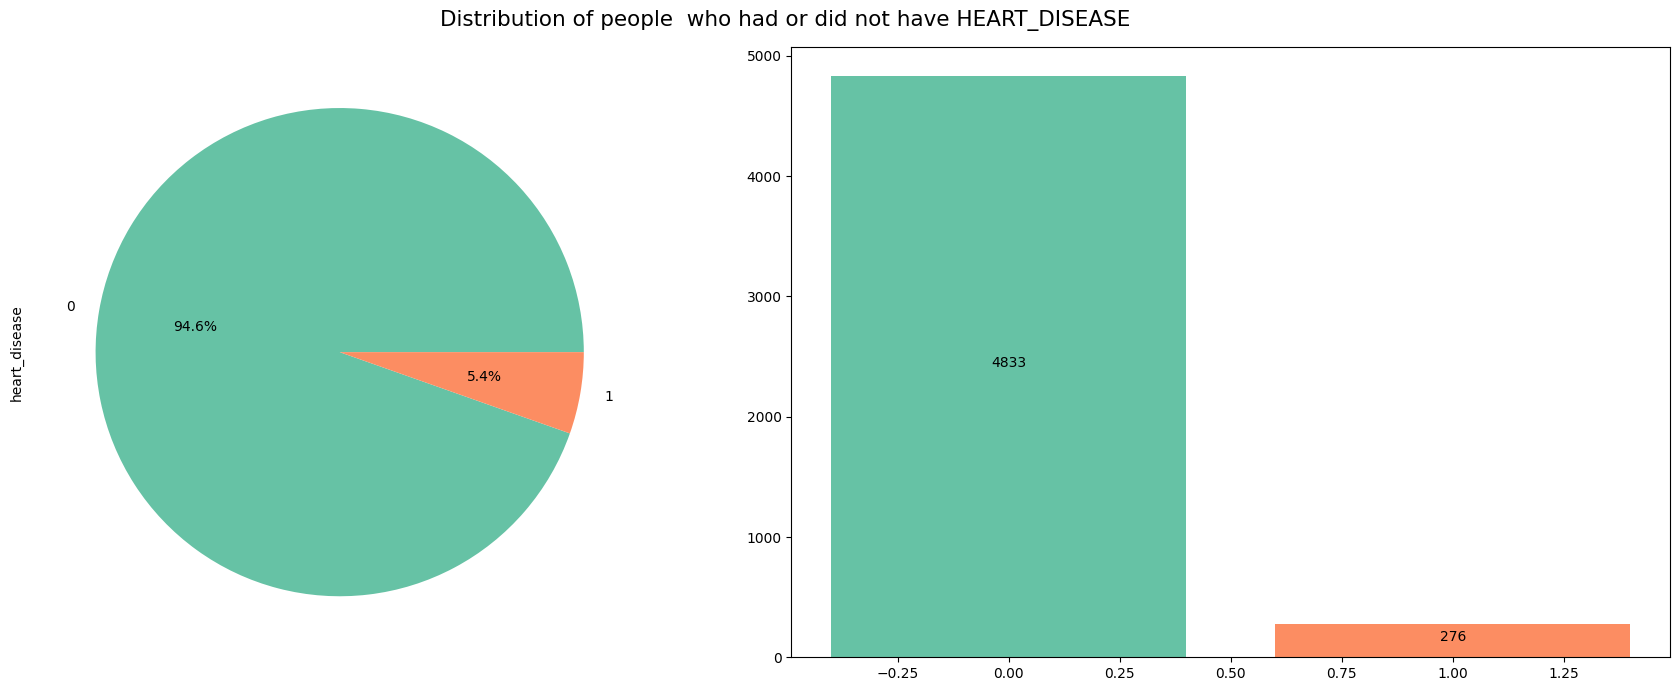

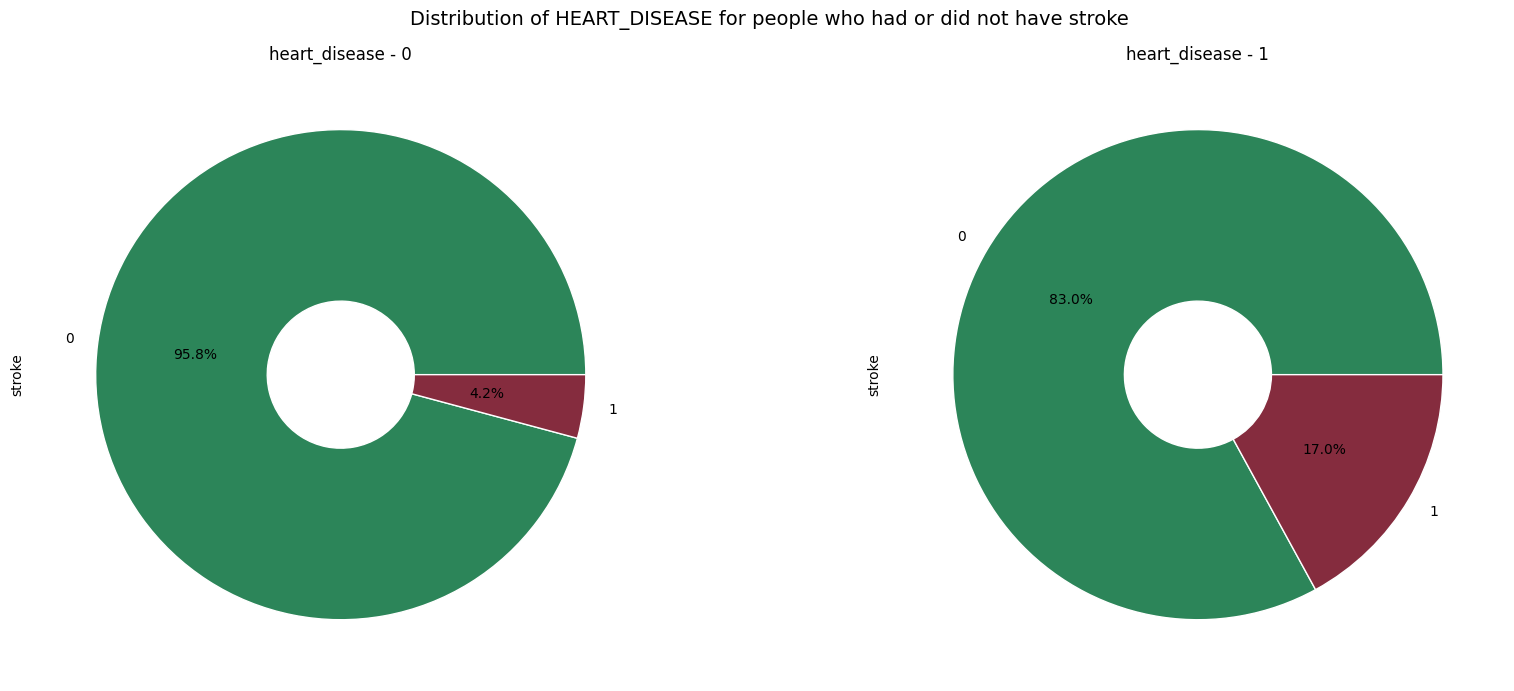

In [709]:
""" Plot work_type distribution in the dataset """
helper_functions.plot_pie_and_bar_with_stroke(df, "heart_disease")

## <a id='feature_exploration'>3. Feature Exploration</a>

Now I can start to explore the correlations between various features. As already seen from the analysis before, it seems that age plays the most important role in predicting the stroke. But I will analyse this with various methods.

I also wanted to see the relationships among numeric values in the dataset.

As seen in the heatmap, age and bmi have somewhat linear relationship. The same is for bmi and avg_glucose_level. However, age and avg_glucose_level does not have a strong relationship.

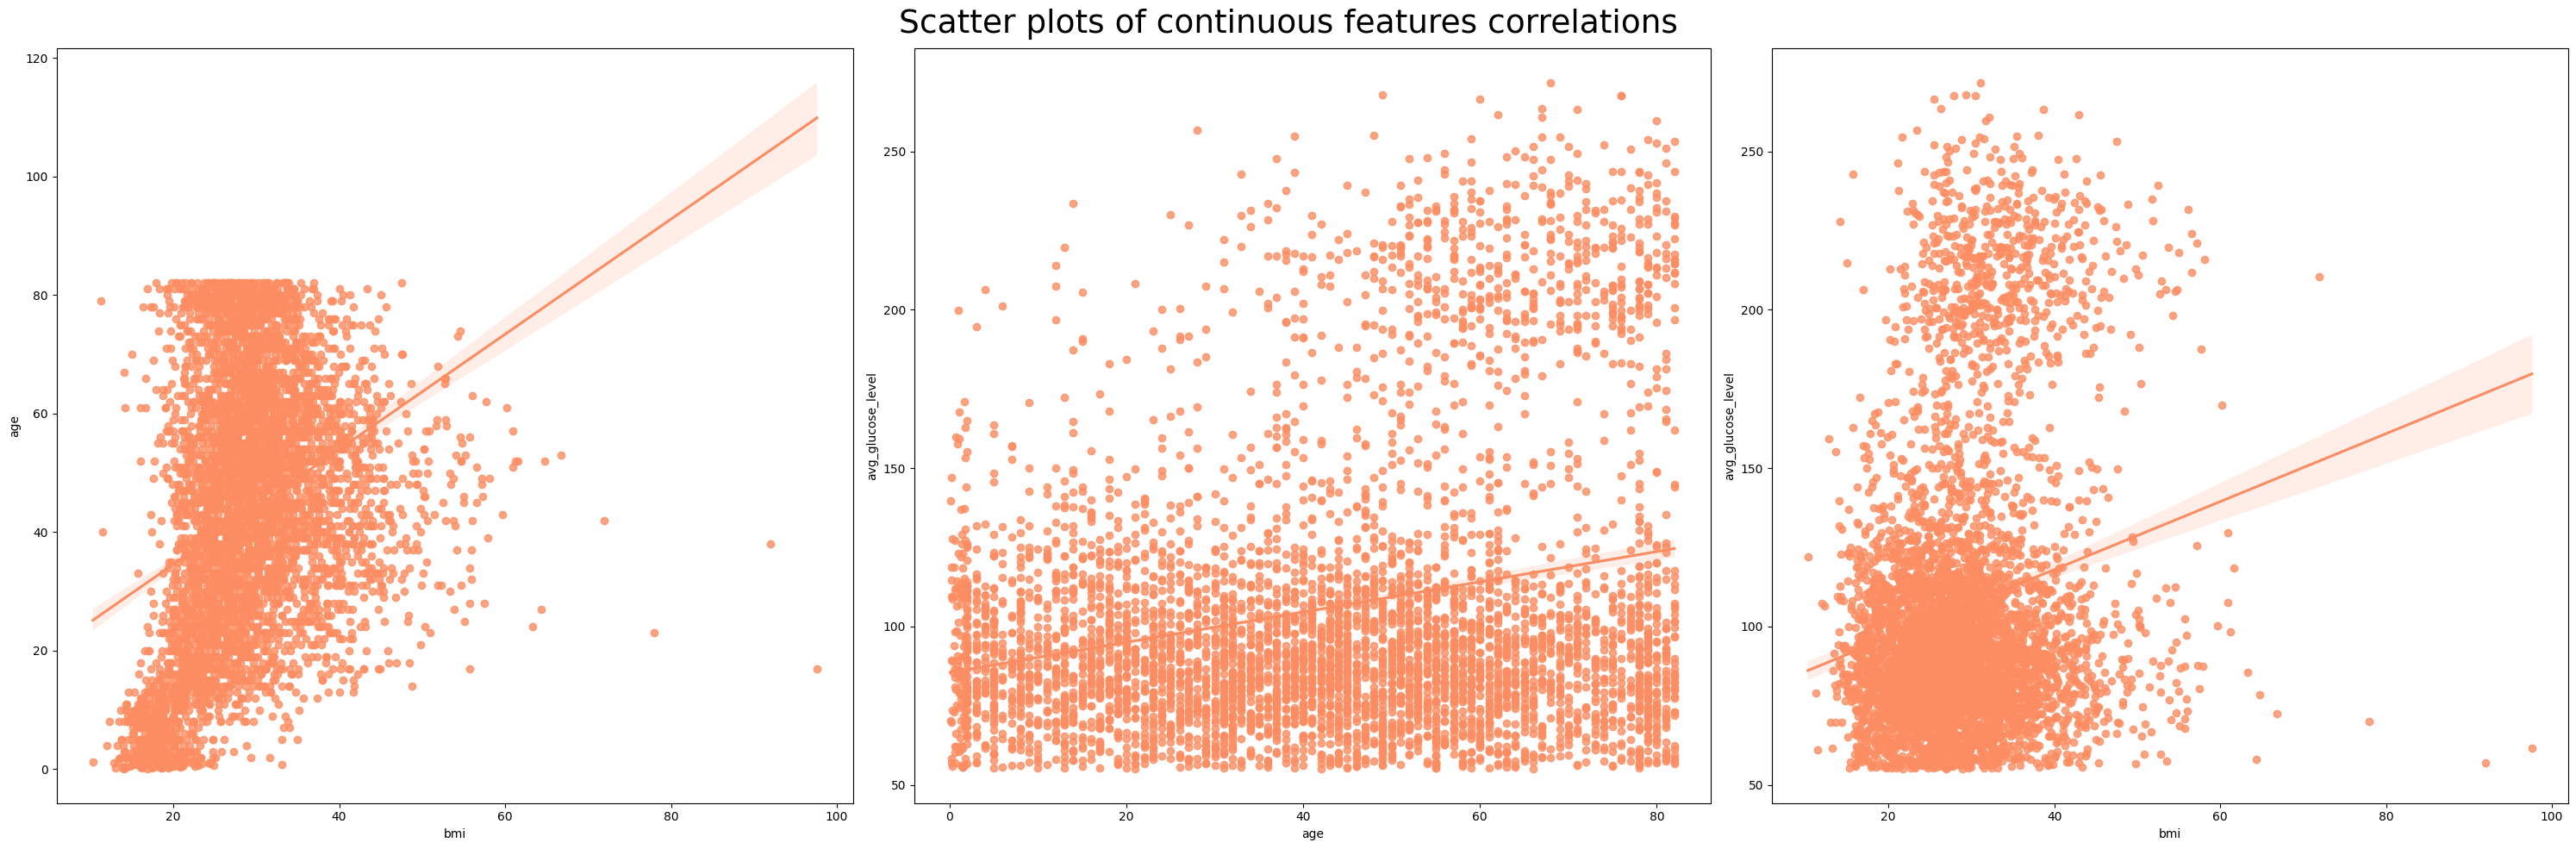

In [710]:
""" Plotting relationships for numerical values """
helper_functions.plot_scatter_plots(df)

I also decided to get the Mutal Information scores for the features we have.

A high mutual information score indicates that a change in the value of one feature is related to a change in the value of the other feature, suggesting that they are dependent on each other.

In [711]:
""" Getting mutal information values for numerical values """
X = df.copy()
y = X.pop("stroke")
X.pop("id")
mi_scores = helper_functions.make_mi_scores(X, y)
mi_scores

age                  0.040300
bmi                  0.008365
work_type            0.007210
ever_married         0.006945
avg_glucose_level    0.006263
hypertension         0.005975
heart_disease        0.005897
smoking_status       0.002142
Residence_type       0.000119
gender               0.000041
Name: MI Scores, dtype: float64

Then, I plotted the results. 

Top 5 features with highest MI scores:
* Age
* BMI
* Work Type
* Ever Married

The least important features were gender and residence type

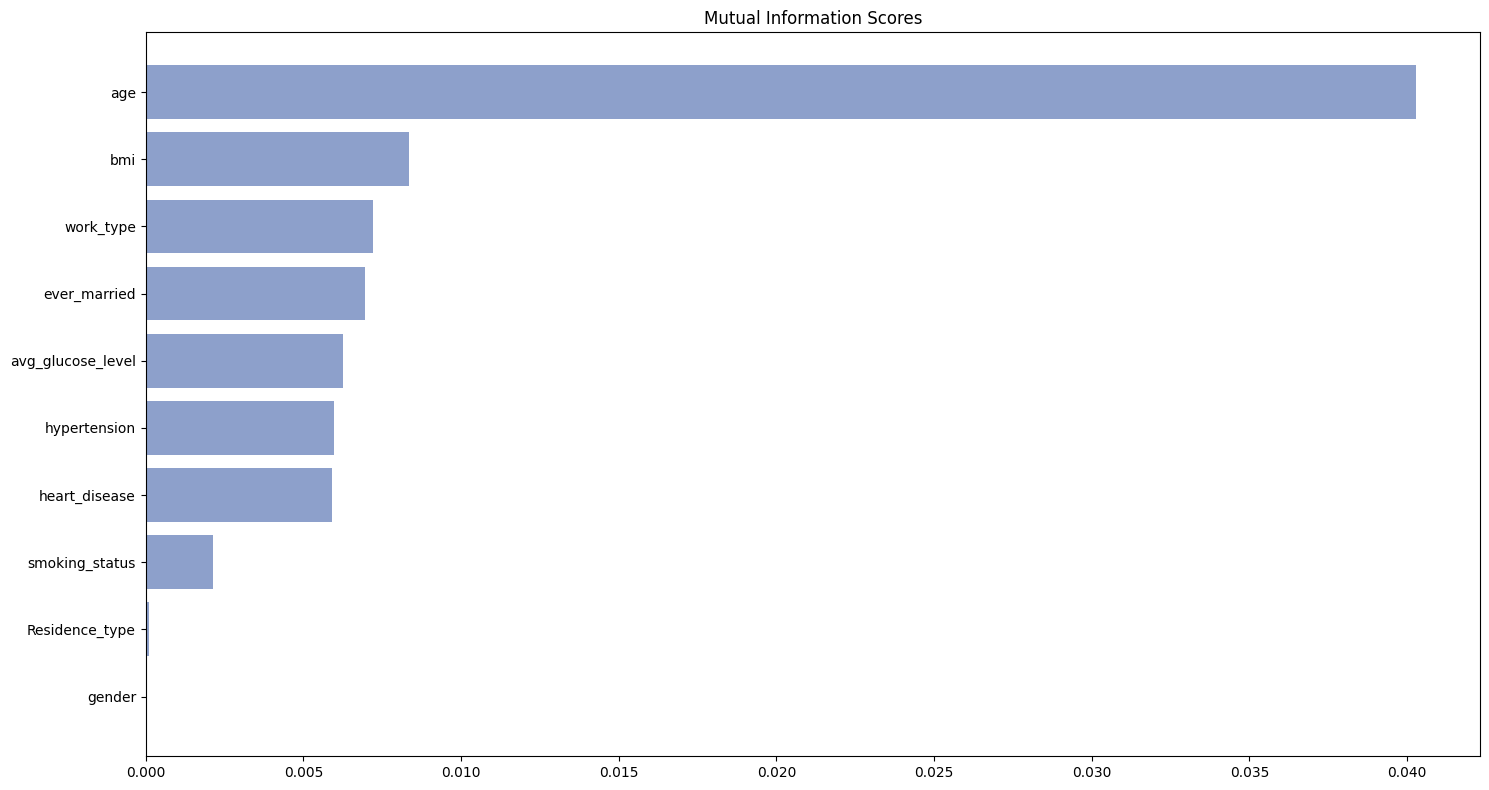

In [712]:
""" Plotting MI scores in bar plot """
helper_functions.plot_mi_scores(mi_scores.head(20))

I also decided to plot the ever_married values together with age and bmi. We can see that marriage status is strongly influenced by age. Therefore, I don't see a strong correlation with stroke as it will be mostly influenced by age.

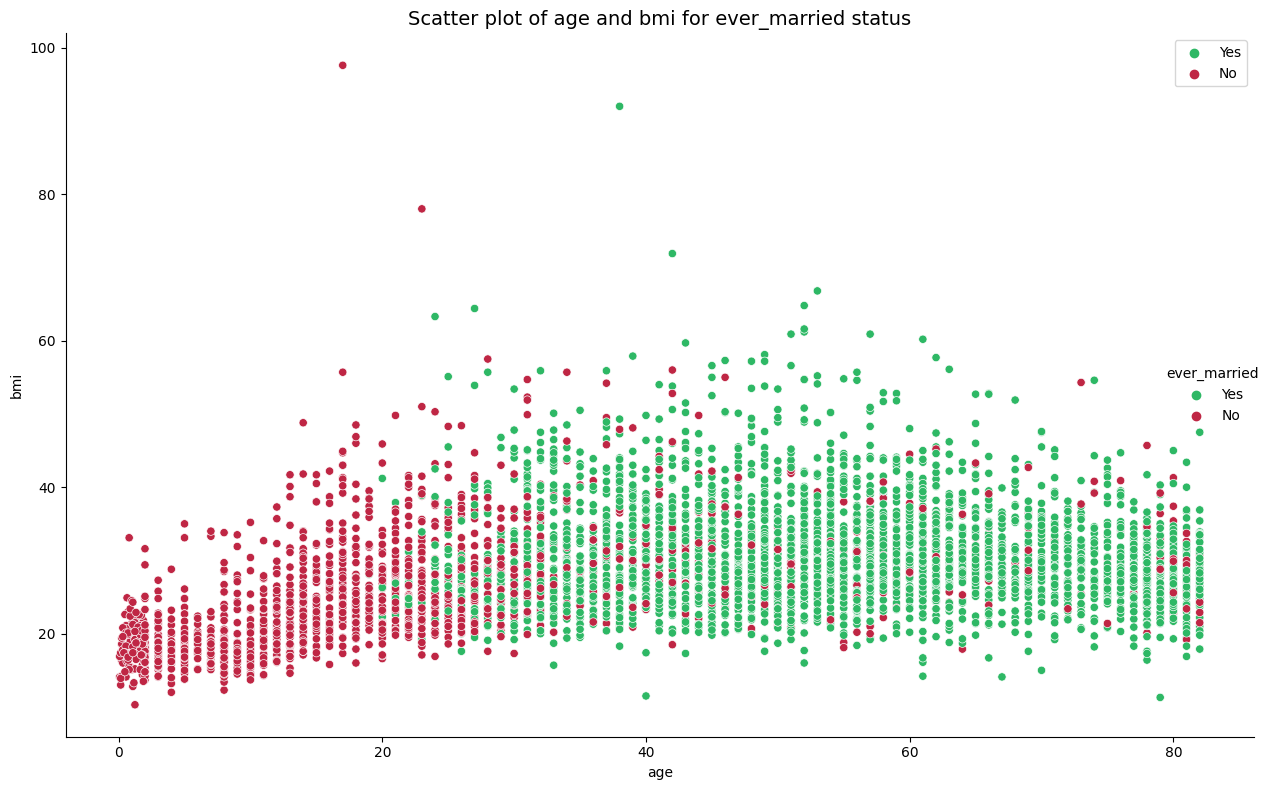

In [713]:
helper_functions.plot_scatter_for_cols(df, 'age', 'bmi', 'ever_married')

I also wanted to try out the autofeat model which selects the most important features automatically.

Autofeat is an automated feature engineering library for machine learning that automatically generates features from raw data to improve model performance. Autofeat uses an ensemble of tree-based models to select the best features.

It returned only age feature.

In [714]:
""" Getting important features with autofeat FeatureSelector """
fsel = FeatureSelector(verbose=1, featsel_runs=10, problem_type="classification")
fselector_features = fsel.fit_transform(pd.DataFrame(X), pd.DataFrame(y))

[featsel] Scaling data...done.
[featsel] Feature selection run 1/10
[featsel] Feature selection run 2/10
[featsel] Feature selection run 3/10
[featsel] Feature selection run 4/10
[featsel] Feature selection run 5/10
[featsel] Feature selection run 6/10
[featsel] Feature selection run 7/10
[featsel] Feature selection run 8/10
[featsel] Feature selection run 9/10
[featsel] Feature selection run 10/10
[featsel] 2 features after 10 feature selection runs
[featsel] 2 features after correlation filtering
[featsel] 1 features after noise filtering


In [715]:
""" Printing out selected features by FeatureSelector """
fselector_features.head()

age
0  67.0
1  61.0
2  80.0
3  49.0
4  79.0

I also decided to create two new features.

* neg_effect_on_lungs - it combines two features Residence_type and smoking_status. I consider that if a person smokes or formerly smoked and lives in an Urban area - then that person would get True for neg_effect_on_lungs feature. Meaning it is daily impacted by harsh environment on their lungs.
* heart_problems - it combines two features heart_disease and hypertension - its true if either of these values is true.

In [716]:
""" Creating new features for negative effect on lungs and heart problems """
df["neg_effect_on_lungs"] = list(
    (df["smoking_status"] == "smokes") |(df["Residence_type"] == "Urban")
)
df["neg_effect_on_lungs"] = df["neg_effect_on_lungs"].map({True: 1, False: 0})
df["heart_problems"] = list((df["heart_disease"] == 1) | (df["hypertension"] == 1))
df["heart_problems"] = df["heart_problems"].map({True: 1, False: 0})

Finally, I have final set of features:
* age
* heart_problems
* neg_effect_on_lungs
* bmi
* ever_married
* work_type
* hypertension
* avg_glucose_level
* heart_disease
* smoking_status 

And our target value - **stroke**

In [717]:
""" Putting final set of features into a list """
final_features = [
    "age",
    "heart_problems",
    "neg_effect_on_lungs",
    "bmi",
    "work_type",
    "hypertension",
    "avg_glucose_level",
    "heart_disease",
    "smoking_status",
    "stroke",
]

## <a id='stroke_prediction'>4. Stroke Prediction</a>

I start my prediction with processing my data.

In [718]:
""" Converting numeric binary categorical values into categorical representation to make it more understandable in OHE """
df_pred = df[final_features].copy() 
df_pred["hypertension"] = df_pred["hypertension"].map({1: "Yes", 0: "No"})
df_pred["heart_disease"] = df_pred["heart_disease"].map({1: "Yes", 0: "No"})
df_pred["neg_effect_on_lungs"] = df_pred["neg_effect_on_lungs"].map({1: "Yes", 0: "No"})
df_pred["heart_problems"] = df_pred["heart_problems"].map({1: "Yes", 0: "No"})

First, I will split data into train, validation and test sets

In [719]:
""" Splitting data into train and test """
cols = list(df_pred.columns)  
cols.remove("stroke") 

x_train, x_test, y_train, y_test = train_test_split(
    df_pred[cols],
    df_pred["stroke"],
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    stratify=df_pred["stroke"],
)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [720]:
""" Getting numerical and non numerical columns into two separate lists """
num_cols = ["age", "bmi", "avg_glucose_level"]
cat_cols = [col for col in x_train.columns if col not in num_cols]

In [721]:
""" Putting training data into separate csv for it to be used for deployed model scaling """
x_train.to_csv("train_data.csv")

### Without over sampling

Since, stroke dataset does not have equal number of target classes. I will have to do the oversampling method, but I wanted to see whether this approach really has an impact.

The models that I wil use for prediction will be 
* Support Vector Machine
* Logistic Regression
* Random Forest Classifier
* XGBoost

In [722]:
""" Putting all used models into a list """
models = {}
for model in [svm.SVC(probability=True), LogisticRegression(), RandomForestClassifier(), XGBClassifier()]:
    numerical_transformer = Pipeline(steps=[
        ('imputer', knn_imputer),
        ('scaler', StandardScaler())
    ])

    cat_encoder = OneHotEncoder(handle_unknown='ignore')
     
    if type(model).__name__ in ['RandomForestClassifier', 'XGBClassifier']: 
        cat_encoder = OrdinalEncoder()

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', cat_encoder)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ])
    preprocessor.fit_transform(x_train)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)
                              ])
    models[model] = pipeline

Since predicting stroke is our goal, the biggest focus will be on recall. 

In the context of predicting health outcomes. Recall measures the proportion of positive instances (e.g. patients with stroke) that were correctly identified by the classifier. In the context of health prediction, high recall is desirable because it means that the classifier is able to correctly identify a large proportion of patients with a certain condition.

Missing a positive case (i.e. failing to identify a patient with stroke) can have serious consequences. For example, if a patient with a potentially serious condition is not properly diagnosed, they may not receive the necessary treatment and their condition may worsen. High recall helps to reduce the risk of missed diagnoses, and ensures that patients receive the appropriate care.

**Recall — out of all the positive examples, how many are predicted as positive?**

In [723]:
""" Performing cross validation for each model and storing their results in a dictionary """
results = {}
for model, pipeline in models.items(): 
    pipeline.fit(x_train, y_train)
    predictions = cross_val_predict(pipeline, x_train, y_train, cv=10)
    avg_recall_score = recall_score(y_train, predictions)
    model_name = type(model).__name__
    test_predictions = pipeline.predict(x_val)
    results[model_name] = test_predictions
    test_recall_score = recall_score(y_val, test_predictions)
    test_str = f'Test data recall for the {model_name} model is: {test_recall_score}\n'
    cross_val_str = f'Cross validated train data recall score is {avg_recall_score}\n'
    header_sep = '-' * int(round((max(len(test_str), len(cross_val_str)) - len(model_name) - 2)/2)) 
    print(f"{header_sep} {model_name} {header_sep}\n{test_str}{cross_val_str}")

--------------------- SVC ---------------------
Test data recall for the SVC model is: 0.0
Cross validated train data recall score is 0.0

------------------- LogisticRegression -------------------
Test data recall for the LogisticRegression model is: 0.0
Cross validated train data recall score is 0.0

-------------------- RandomForestClassifier --------------------
Test data recall for the RandomForestClassifier model is: 0.0
Cross validated train data recall score is 0.018867924528301886

------------------------ XGBClassifier ------------------------
Test data recall for the XGBClassifier model is: 0.0
Cross validated train data recall score is 0.050314465408805034



We can see that all of the models are really good at predicting people who did not have stroke. Of course, this is because the dataset contained more people without stroke. Therefore, the recall for class 1 is very low. Oversampling/undersampling techniques are really necessary in this case.

In [724]:
""" Displaying each models results in dataframes """
for model in results.keys():
    print(model)
    display(
        pd.DataFrame(
            classification_report(y_val, results[model], output_dict=True)
        ).transpose()
    )

SVC


precision  recall  f1-score   support
0              0.951100  1.0000  0.974937  778.0000
1              0.000000  0.0000  0.000000   40.0000
accuracy       0.951100  0.9511  0.951100    0.9511
macro avg      0.475550  0.5000  0.487469  818.0000
weighted avg   0.904592  0.9511  0.927263  818.0000

LogisticRegression


precision  recall  f1-score   support
0              0.951100  1.0000  0.974937  778.0000
1              0.000000  0.0000  0.000000   40.0000
accuracy       0.951100  0.9511  0.951100    0.9511
macro avg      0.475550  0.5000  0.487469  818.0000
weighted avg   0.904592  0.9511  0.927263  818.0000

RandomForestClassifier


precision    recall  f1-score     support
0              0.951040  0.998715  0.974295  778.000000
1              0.000000  0.000000  0.000000   40.000000
accuracy       0.949878  0.949878  0.949878    0.949878
macro avg      0.475520  0.499357  0.487147  818.000000
weighted avg   0.904535  0.949878  0.926652  818.000000

XGBClassifier


precision    recall  f1-score     support
0              0.950311  0.983290  0.966519  778.000000
1              0.000000  0.000000  0.000000   40.000000
accuracy       0.935208  0.935208  0.935208    0.935208
macro avg      0.475155  0.491645  0.483260  818.000000
weighted avg   0.903841  0.935208  0.919257  818.000000

The results of all these classifiers can be seen in the normalized confusion matrices.

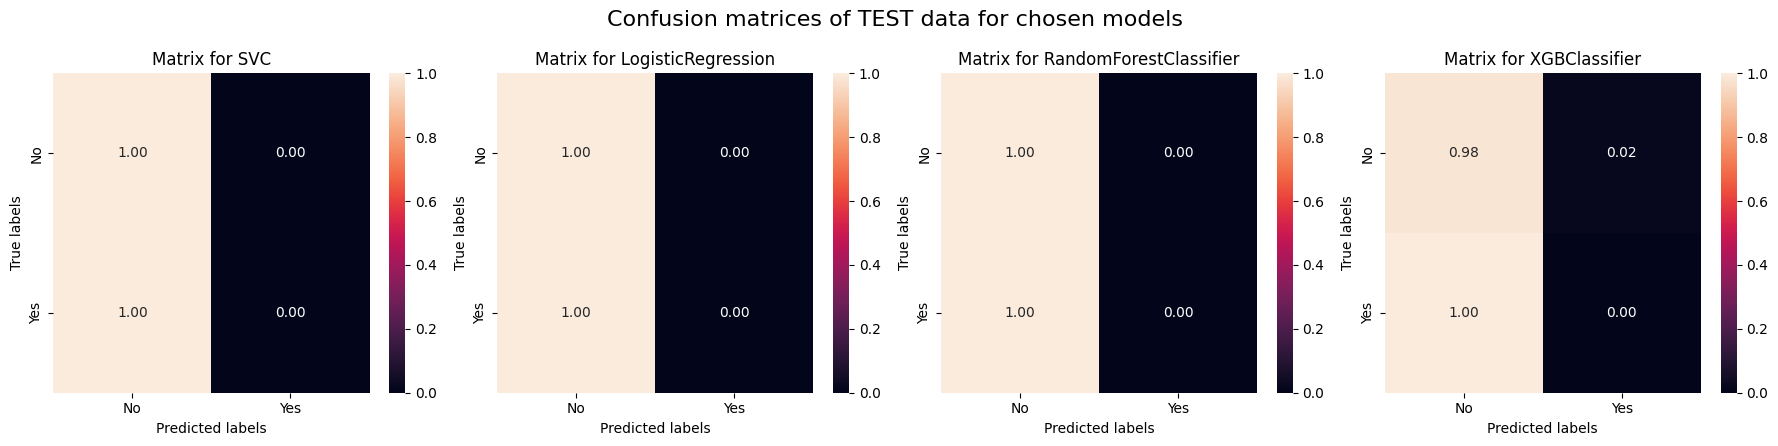

In [725]:
""" Plotting each models confusion matrices of the train data """
helper_functions.plot_conf_matrices(results, y_val)

### Combining SMOTE and undersampling

Since the stroke data is very imbalanced, oversampling or undersampling is important to use. Since the scope of imbalance is really high, I decided that the best way would be to combine oversampling and undersampling. 

One of the most popular oversampling method is the Synthetic Minority Oversampling Technique, or SMOTE. SMOTE selects two existing samples from the minority class, and then generates a new sample at a random point between the two selected samples. The new sample is added to the dataset, and the process is repeated until the minority class is balanced with the majority class.

In [726]:
''' Initializing oversampling (SMOTE) '''
over = SMOTE(sampling_strategy=0.5)

In [727]:
for mdl, mdl_pipeline in models.items():
    pipe = mdl_pipeline
    pipe.steps.insert(1, ['smote', over])
    models[mdl] = pipe

In [728]:
results = {}
for model, pipeline in models.items(): 
    pipeline.fit(x_train, y_train)
    predictions = cross_val_predict(pipeline, x_train, y_train, cv=10)
    avg_recall_score = recall_score(y_train, predictions)
    model_name = type(model).__name__
    test_predictions = pipeline.predict(x_val)
    results[model_name] = test_predictions
    test_recall_score = recall_score(y_val, test_predictions)
    test_str = f'Test data recall for the {model_name} model is: {test_recall_score}\n'
    cross_val_str = f'Cross validated train data recall score is {avg_recall_score}\n'
    header_sep = '-' * int(round((max(len(test_str), len(cross_val_str)) - len(model_name) - 2)/2)) 
    print(f"{header_sep} {model_name} {header_sep}\n{test_str}{cross_val_str}")

---------------------------- SVC ----------------------------
Test data recall for the SVC model is: 0.2
Cross validated train data recall score is 0.389937106918239

--------------------- LogisticRegression ---------------------
Test data recall for the LogisticRegression model is: 0.625
Cross validated train data recall score is 0.5849056603773585

-------------------- RandomForestClassifier --------------------
Test data recall for the RandomForestClassifier model is: 0.025
Cross validated train data recall score is 0.13836477987421383

------------------------ XGBClassifier ------------------------
Test data recall for the XGBClassifier model is: 0.0
Cross validated train data recall score is 0.08176100628930817



We can see that now models perform better at predicting both of the classes. Still, it behaves better for predicting people without stroke, but we can see a major improvement.

In [729]:
""" Displaying each models results in dataframes """
for model in results.keys():
    print(model)
    display(
        pd.DataFrame(
            classification_report(y_val, results[model], output_dict=True)
        ).transpose()
    )

SVC


precision    recall  f1-score     support
0              0.954286  0.858612  0.903924  778.000000
1              0.067797  0.200000  0.101266   40.000000
accuracy       0.826406  0.826406  0.826406    0.826406
macro avg      0.511041  0.529306  0.502595  818.000000
weighted avg   0.910937  0.826406  0.864674  818.000000

LogisticRegression


precision    recall  f1-score     support
0              0.977134  0.823907  0.894003  778.000000
1              0.154321  0.625000  0.247525   40.000000
accuracy       0.814181  0.814181  0.814181    0.814181
macro avg      0.565728  0.724454  0.570764  818.000000
weighted avg   0.936899  0.814181  0.862390  818.000000

RandomForestClassifier


precision    recall  f1-score     support
0              0.950882  0.970437  0.960560  778.000000
1              0.041667  0.025000  0.031250   40.000000
accuracy       0.924205  0.924205  0.924205    0.924205
macro avg      0.496274  0.497719  0.495905  818.000000
weighted avg   0.906421  0.924205  0.915117  818.000000

XGBClassifier


precision    recall  f1-score    support
0              0.949622  0.969152  0.959288  778.00000
1              0.000000  0.000000  0.000000   40.00000
accuracy       0.921760  0.921760  0.921760    0.92176
macro avg      0.474811  0.484576  0.479644  818.00000
weighted avg   0.903186  0.921760  0.912379  818.00000

Thus far, the Logistic Regression model has demonstrated the most favorable results, while the Random Forest classifier has exhibited the least optimal performance.

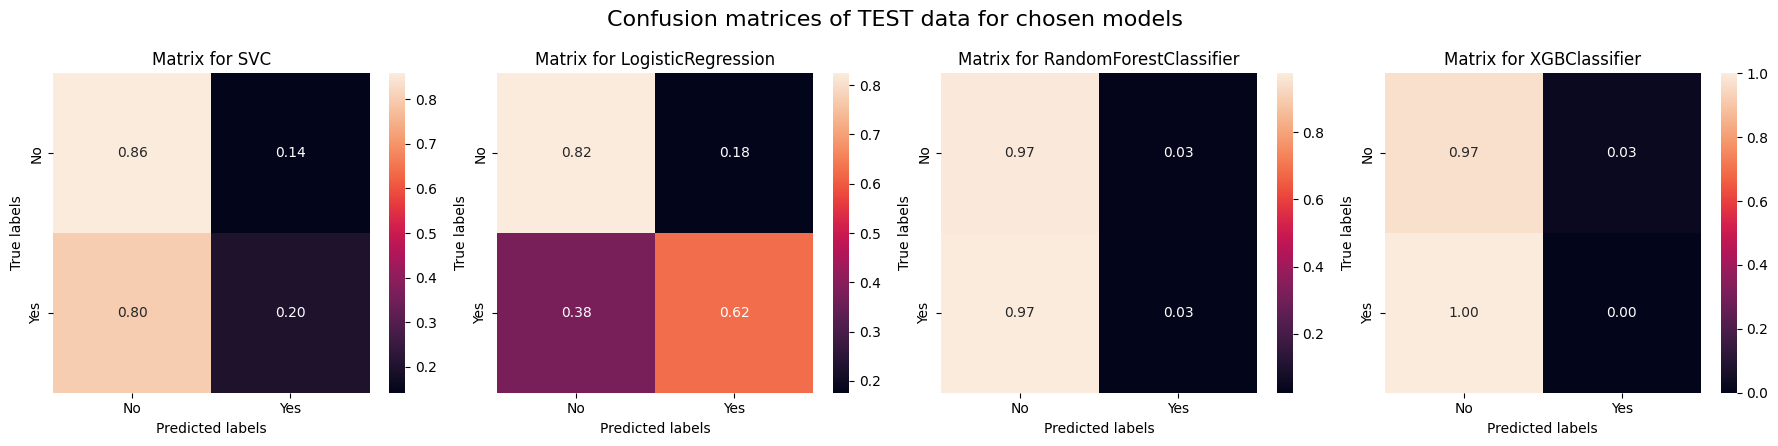

In [730]:
helper_functions.plot_conf_matrices(results, y_val)

### Hyper Parameter Tuning

Hyperparameter tuning is important in machine learning because it helps to optimize the performance of a model by finding the best values for its hyperparameters. The values of the hyperparameters can have a significant impact on the performance of a model, and finding the best values is crucial for achieving good performance. Therefore, now I will tune each of the models.

In [731]:
results = {}

#### SVM

Support Vector Machine (SVM) is a commonly used machine learning algorithm, and hyperparameter tuning is an important step in optimizing its performance.

It is important to define the search space: identify the hyperparameters that you want to tune and the possible values for each parameter. For example, you might want to tune the regularization parameter "C" and the kernel parameter "gamma."

In [732]:
C = [i / 100 for i in range(5, 105, 10)]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ["linear", "poly", "rbf"]
param_grid = {"model__C": C, "model__gamma": gamma, "model__kernel": kernel}

In [733]:
""" Performing RandomizedSearch cross validation for SVM model """
svm_model = list(models.values())[0]
gs = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_grid,
    scoring="recall",
    n_iter=25,
    n_jobs=3,
)
gs.fit(x_train, y_train)

best_svm_model = gs.best_estimator_
test_predictions = best_svm_model.predict(x_val)
results["SVM"] = test_predictions
test_recall_score = recall_score(y_val, test_predictions)

best_params = f"Chosen best parameters for SVM model - {gs.best_params_}"
test_str = f'Tuned SVM model test data recall is: {test_recall_score}\n'
cross_val_str = f'Tuned SVM model cross validated train data recall score is {gs.score(x_train, y_train)}' 
print(f"-------- Support Vector Machine --------\n{best_params}{test_str}{cross_val_str}")

-------- Support Vector Machine --------
Chosen best parameters for SVM model - {'model__kernel': 'linear', 'model__gamma': 0.2, 'model__C': 0.85}Tuned SVM model test data recall is: 0.65
Tuned SVM model cross validated train data recall score is 0.6540880503144654


#### Logistic Regression

Tuning a logistic regression model involves finding the best values for its hyperparameters to optimize its performance.

It is important to define the hyperparameters to be tuned. Common hyperparameters in logistic regression include the regularization parameter (e.g., L1 or L2), the solver method, and the inverse of regularization strength (C).

In [734]:
solvers = ["newton-cg", "lbfgs", "liblinear"]
penalty = ["l1", "l2"] 
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = dict(model__solver=solvers, model__penalty=penalty, model__C=c_values, model__max_iter=[1000])

In [735]:
""" Performing RandomizedSearch cross validation for Logistic Regression model """
lg_model = list(models.values())[1]
gs = RandomizedSearchCV(
    estimator=lg_model,
    param_distributions=param_grid,
    scoring="recall",
    n_iter=25,
    n_jobs=3,
)
gs.fit(x_train, y_train)

best_lg_model = gs.best_estimator_
test_predictions = best_lg_model.predict(x_val)
results["LogisticRegression"] = test_predictions
test_recall_score = recall_score(y_val, test_predictions)

best_params = f"Chosen best parameters for LogisticRegression model - {gs.best_params_}\n"
test_str = f'Tuned LogisticRegression model test data recall is: {test_recall_score}\n'
cross_val_str = f'Tuned LogisticRegression model cross validated train data recall score is {gs.score(x_train, y_train)}' 
print(f"-------------- Logistic Regression --------------\n{best_params}{test_str}{cross_val_str}")

-------------- Logistic Regression --------------
Chosen best parameters for LogisticRegression model - {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__max_iter': 1000, 'model__C': 0.01}
Tuned LogisticRegression model test data recall is: 0.625
Tuned LogisticRegression model cross validated train data recall score is 0.6540880503144654


#### Random Forest Classifier

Tuning a random forest classifier:

Define the hyperparameters to be tuned: Common hyperparameters in a random forest classifier include the number of trees in the forest, the maximum depth of each tree, the minimum number of samples required to split an internal node, and the minimum number of samples required to be at a leaf node.

In [736]:
n_estimators = range(100, 500, 100)  # number of trees in the random forest
max_depth = [
    1,
    5,
    10,
    15,
    20,
    25,
    30,
]  # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]  # minimum sample number to split a node
min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node

param_grid = {
    "model__n_estimators": n_estimators,
    "model__max_depth": max_depth,
    "model__min_samples_split": min_samples_split,
    "model__min_samples_leaf": min_samples_leaf,
}

In [737]:
""" Performing RandomizedSearch cross validation for Random Forest model """
rf_model = list(models.values())[2]
gs = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    scoring="recall",
    n_iter=25,
    n_jobs=3,
)
gs.fit(x_train, y_train)

best_rf_model = gs.best_estimator_
test_predictions = best_rf_model.predict(x_val)
results["RandomForest"] = test_predictions
test_recall_score = recall_score(y_val, test_predictions)

best_params = f"Chosen best parameters for RandomForest model - {gs.best_params_}"
test_str = f'Tuned RandomForest model test data recall is: {test_recall_score}\n'
cross_val_str = f'Tuned RandomForest model cross validated train data recall score is {gs.score(x_train, y_train)}' 
print(f"----------------- Random Forest -----------------\n{best_params}{test_str}{cross_val_str}")

----------------- Random Forest -----------------
Chosen best parameters for RandomForest model - {'model__n_estimators': 300, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__max_depth': 5}Tuned RandomForest model test data recall is: 0.4
Tuned RandomForest model cross validated train data recall score is 0.610062893081761


#### XGBoost Classifier

Tuning XGBoost: choose an appropriate evaluation metric: Depending on the problem, you might want to choose a different evaluation metric such as accuracy, F1-score, precision, recall, AUC, etc.

In [738]:
""" Setting up parameters for XGBoost hyperparameter tuning """
param_grid = { 
    "model__gamma": [
        0,
        0.1,
        0.2,
        0.4,
        0.8,
        1.6,
        3.2,
        6.4,
        12.8,
        25.6,
        51.2,
        102.4,
        200,
    ],
    "model__learning_rate": [
        0.01,
        0.03,
        0.06,
        0.1,
        0.15,
        0.2,
        0.25,
        0.300000012,
        0.4,
        0.5,
        0.6,
        0.7,
    ],
    "model__max_depth": [2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    "model__n_estimators": [50, 65, 80, 100, 115, 130, 150],
    "model__reg_alpha": [
        0,
        0.1,
        0.2,
        0.4,
        0.8,
        1.6,
        3.2,
        6.4,
        12.8,
        25.6,
        51.2,
        102.4,
        200,
    ],
    "model__reg_lambda": [
        0,
        0.1,
        0.2,
        0.4,
        0.8,
        1.6,
        3.2,
        6.4,
        12.8,
        25.6,
        51.2,
        102.4,
        200,
    ],
    "model__subsample": [0.75, 1],
    "model__colsample_bytree": [0.75, 1],
    "model__min_child_weight": [1, 5],
}

In [739]:
""" Performing RandomizedSearch cross validation for XGBoost model """
xgb_model = list(models.values())[3]
gs = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring="recall",
    n_iter=25,
    n_jobs=3,
)
gs.fit(x_train, y_train)

best_xgb_model = gs.best_estimator_
test_predictions = best_xgb_model.predict(x_val)
results["XGBoost"] = test_predictions
test_recall_score = recall_score(y_val, test_predictions)

best_params = f"Chosen best parameters for XGBoost model - {gs.best_params_}"
test_str = f'Tuned XGBoost model test data recall is: {test_recall_score}\n'
cross_val_str = f'Tuned XGBoost model cross validated train data recall score is {gs.score(x_train, y_train)}' 
print(f"----------------- XGBoost Classifier -----------------\n{best_params}{test_str}{cross_val_str}")

----------------- XGBoost Classifier -----------------
Chosen best parameters for XGBoost model - {'model__subsample': 1, 'model__reg_lambda': 1.6, 'model__reg_alpha': 51.2, 'model__n_estimators': 65, 'model__min_child_weight': 1, 'model__max_depth': 10, 'model__learning_rate': 0.6, 'model__gamma': 200, 'model__colsample_bytree': 1}Tuned XGBoost model test data recall is: 0.85
Tuned XGBoost model cross validated train data recall score is 0.8427672955974843


As a result of our hyperparameter tuning efforts, the XGBoost model emerges as the clear winner, boasting a robust recall rate of 72% in correctly identifying stroke cases among all patients diagnosed. While SVM performs moderately well as a runner-up, the Random Forest classifier lags behind as the lowest performing model.

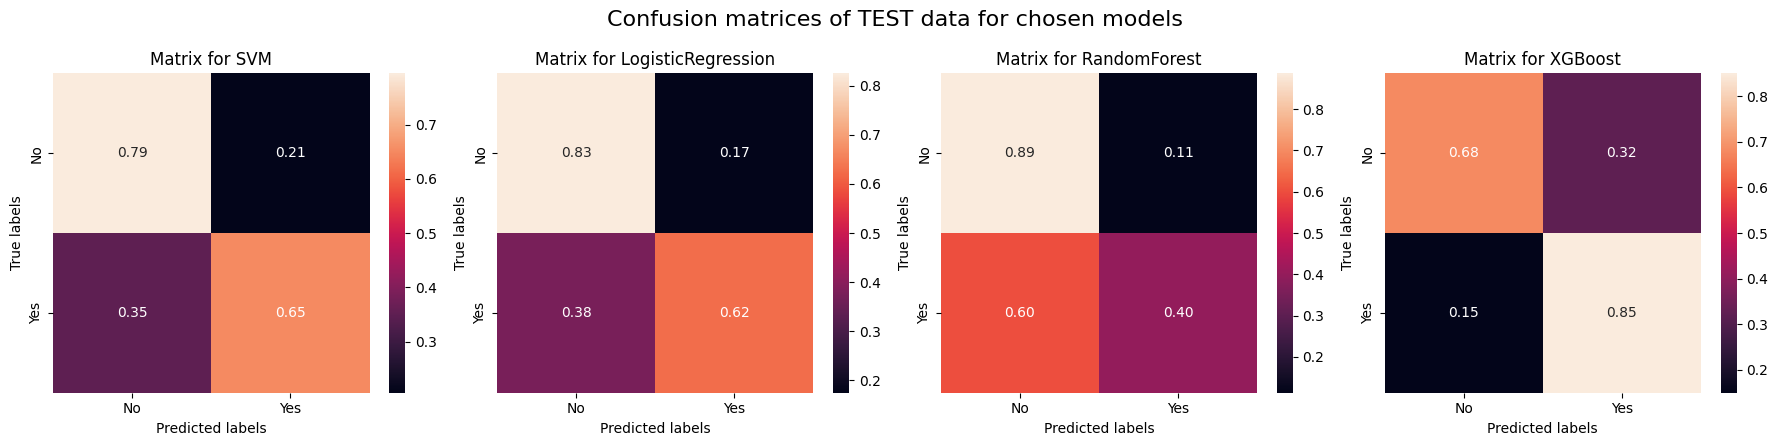

In [740]:
""" Plotting tuned models confusion matrices on train data """
helper_functions.plot_conf_matrices(results, y_val)

I also printed each model results so see the real numbers.

In [741]:
""" Displaying results of tuned models """
for model in results.keys():
    print(model)
    display(
        pd.DataFrame(
            classification_report(y_val, results[model], output_dict=True)
        ).transpose()
    )

SVM


precision    recall  f1-score     support
0              0.977848  0.794344  0.876596  778.000000
1              0.139785  0.650000  0.230088   40.000000
accuracy       0.787286  0.787286  0.787286    0.787286
macro avg      0.558817  0.722172  0.553342  818.000000
weighted avg   0.936867  0.787286  0.844982  818.000000

LogisticRegression


precision    recall  f1-score     support
0              0.977169  0.825193  0.894774  778.000000
1              0.155280  0.625000  0.248756   40.000000
accuracy       0.815403  0.815403  0.815403    0.815403
macro avg      0.566224  0.725096  0.571765  818.000000
weighted avg   0.936979  0.815403  0.863183  818.000000

RandomForest


precision    recall  f1-score     support
0              0.966387  0.886889  0.924933  778.000000
1              0.153846  0.400000  0.222222   40.000000
accuracy       0.863081  0.863081  0.863081    0.863081
macro avg      0.560116  0.643445  0.573578  818.000000
weighted avg   0.926654  0.863081  0.890571  818.000000

XGBoost


precision    recall  f1-score     support
0              0.988764  0.678663  0.804878  778.000000
1              0.119718  0.850000  0.209877   40.000000
accuracy       0.687042  0.687042  0.687042    0.687042
macro avg      0.554241  0.764332  0.507377  818.000000
weighted avg   0.946268  0.687042  0.775783  818.000000

The ROC curve may not provide a definitive comparison between the models, but it can still prove invaluable in determining the appropriate threshold for making predictions, ultimately benefiting the selection process.

SVC AUC for validation data 0.831073264781491
LogisticRegression AUC for validation data 0.8417095115681235
RandomForestClassifier AUC for validation data 0.8291452442159383
XGBClassifier AUC for validation data 0.7912275064267353


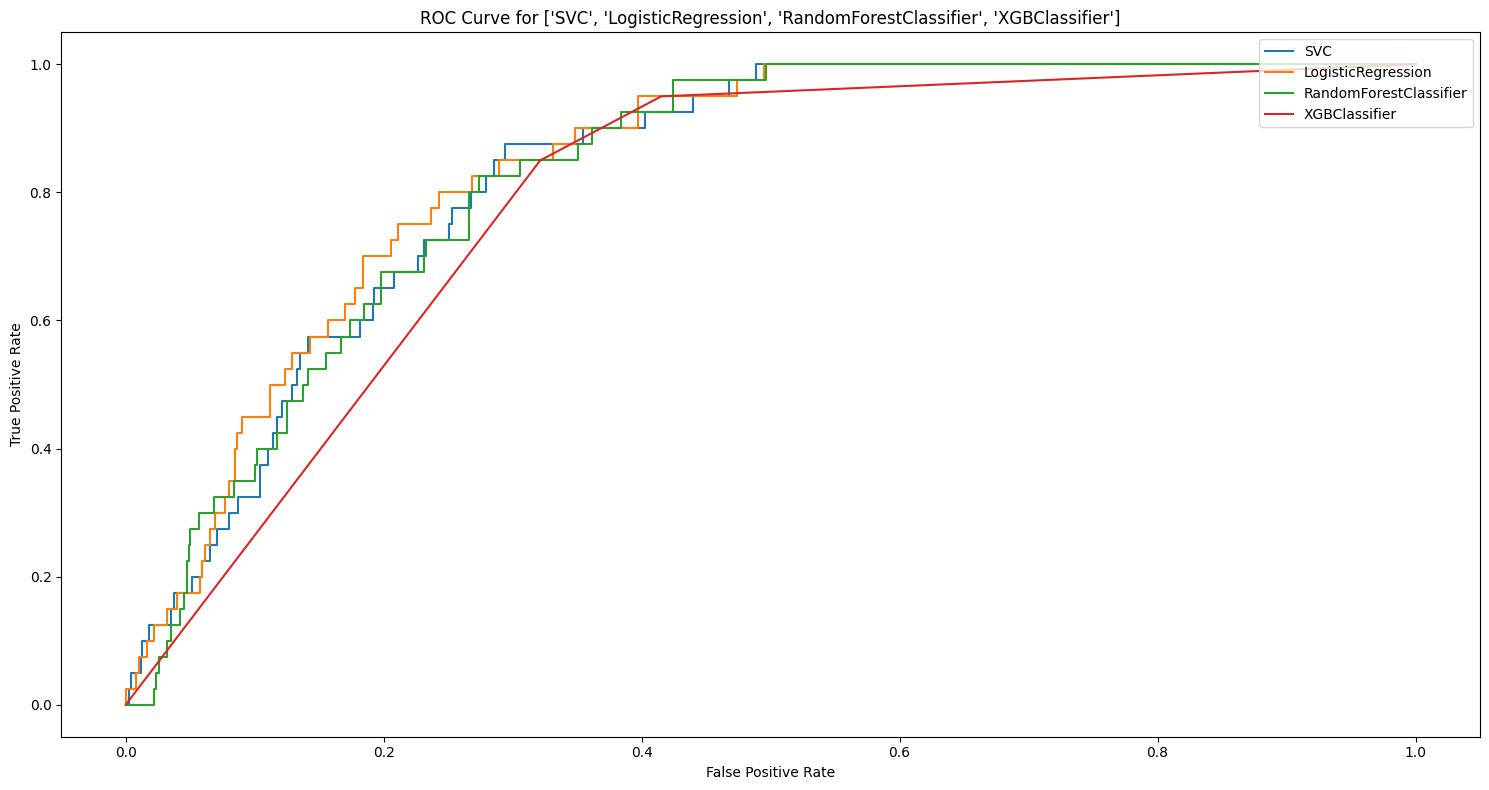

In [742]:
""" Plotting the ROC curve for final set of models """
helper_functions.plot_roc(
    x_val, y_val, "validation", [best_svm_model, best_lg_model, best_rf_model, best_xgb_model]
)

##### Predicting Test Data

Same as with validation set, XGBoost is giving the best results for test data as well.

In [743]:
""" Predicting test data with final set of models"""
results["SVM"] = best_svm_model.predict(x_test)
results["LogisticRegression"] = best_lg_model.predict(x_test)
results["RandomForest"] = best_rf_model.predict(x_test)
results["XGBoost"] = best_xgb_model.predict(x_test)

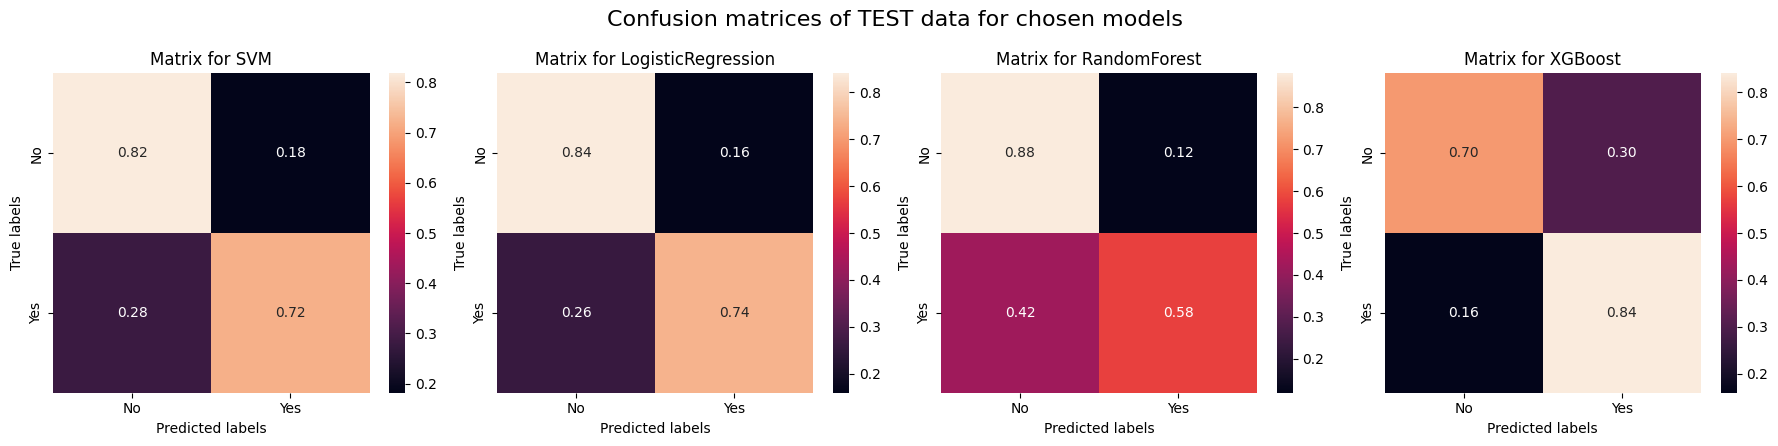

In [744]:
""" Plotting the confusion matrix for test data """
helper_functions.plot_conf_matrices(results, y_test)

In [745]:
""" Displaying the results of test data prediction """
for model in results.keys():
    print(model)
    display(
        pd.DataFrame(
            classification_report(y_test, results[model], output_dict=True)
        ).transpose()
    )

SVM


precision    recall  f1-score      support
0              0.982695  0.817901  0.892757   972.000000
1              0.169014  0.720000  0.273764    50.000000
accuracy       0.813112  0.813112  0.813112     0.813112
macro avg      0.575854  0.768951  0.583261  1022.000000
weighted avg   0.942886  0.813112  0.862473  1022.000000

LogisticRegression


precision    recall  f1-score      support
0              0.984337  0.840535  0.906770   972.000000
1              0.192708  0.740000  0.305785    50.000000
accuracy       0.835616  0.835616  0.835616     0.835616
macro avg      0.588523  0.790267  0.606278  1022.000000
weighted avg   0.945608  0.835616  0.877368  1022.000000

RandomForest


precision    recall  f1-score      support
0              0.976055  0.880658  0.925906   972.000000
1              0.200000  0.580000  0.297436    50.000000
accuracy       0.865949  0.865949  0.865949     0.865949
macro avg      0.588027  0.730329  0.611671  1022.000000
weighted avg   0.938087  0.865949  0.895159  1022.000000

XGBoost


precision    recall  f1-score      support
0              0.988338  0.697531  0.817853   972.000000
1              0.125000  0.840000  0.217617    50.000000
accuracy       0.704501  0.704501  0.704501     0.704501
macro avg      0.556669  0.768765  0.517735  1022.000000
weighted avg   0.946101  0.704501  0.788487  1022.000000

##### Selecting Right Threshold

Since the stroke prediction data is sensitive, I think that taking larger threshold value is better to reduce number of false negatives - where person actually had stroke but the model predicted it as false.

Thus from the ROC I will retrieve best threshold in order to maximize the recall_score and minimize false negatives.

In [746]:
""" Selecting best threshold based on train data """
predictions = best_svm_model.predict(x_val)
predicted_proba = best_svm_model.predict_proba(x_val)
false_pos_rate, true_pos_rate, proba = roc_curve(y_val, predicted_proba[:, -1])
optimal_proba_cutoff = proba[true_pos_rate.argmax()]

val_roc_predictions = [
    1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]
]
print(
    "VALIDATION DATA Recall Score Before and After Thresholding: {}, {}".format(
        recall_score(y_val, predictions), recall_score(y_val, val_roc_predictions)
    )
)

VALIDATION DATA Recall Score Before and After Thresholding: 0.65, 1.0


In [747]:
""" Checking recall with the best threshold for test data """
predictions = best_svm_model.predict(x_test)
predicted_proba = best_svm_model.predict_proba(x_test)
test_roc_predictions = [
    1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]
]
print(
    "TEST DATA Recall Score Before and After Thresholding: {}, {}".format(
        recall_score(y_test, predictions), recall_score(y_test, test_roc_predictions)
    )
)

TEST DATA Recall Score Before and After Thresholding: 0.72, 0.86


We can see that with this particular threshold the model falsely predicts more people without stroke as the ones who have stroke, but now we can see that now it has more people with stroke predicted correctly.

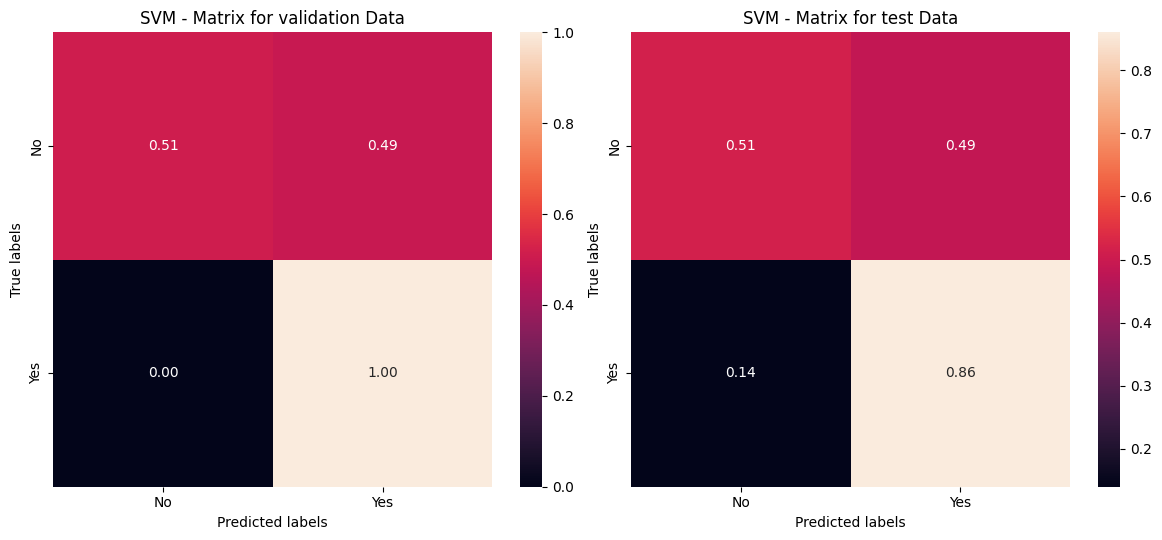

In [748]:
''' Plotting confusion matrix for chosen threshold '''
helper_functions.plot_roc_conf_matrices(
    y_val, y_test, "SVM", "validation", "test", val_roc_predictions, test_roc_predictions
)

##### Investigating Feature Importance

Now, I wanted to see feature importances with module SHAP. Since the second best model was SVM I will check both SVM and XGBoost classifiers feature importance scores. 

We can see that XGBoost mostly depends on the age feature. Tree-based models can overtrain by relying too heavily on the strongest feature. In tree-based models, each split in the tree is based on the feature that provides the most reduction in impurity. This can lead to the model placing too much importance on a single feature and overfitting the training data.

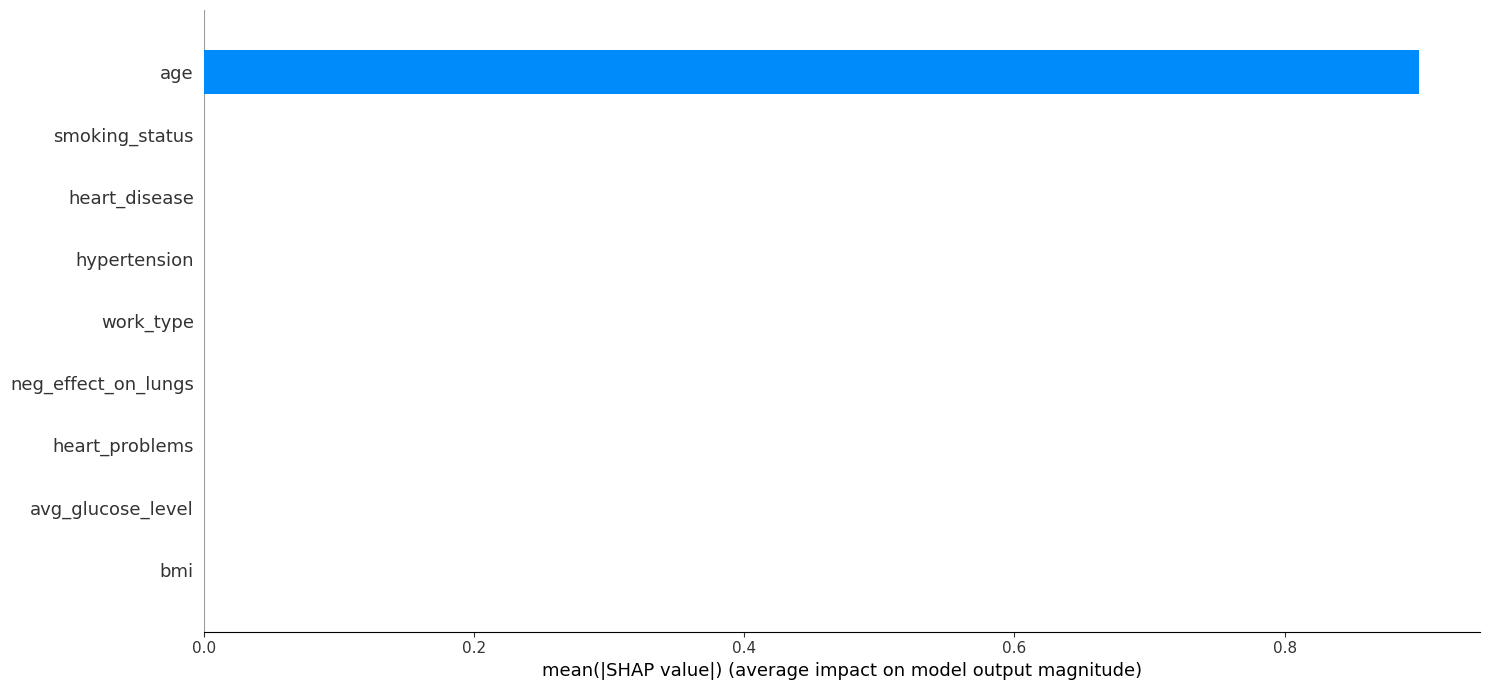

In [749]:
''' Setting shap values for XGBoost '''
explainer = shap.TreeExplainer(best_xgb_model['model'])

#apply the preprocessing to x_test
observations = best_xgb_model['preprocessor'].transform(x_val)
observations = pd.DataFrame(observations) 
observations.columns = [col[5:] for col in best_xgb_model['preprocessor'].get_feature_names_out()]

#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar", plot_size=[15,7])

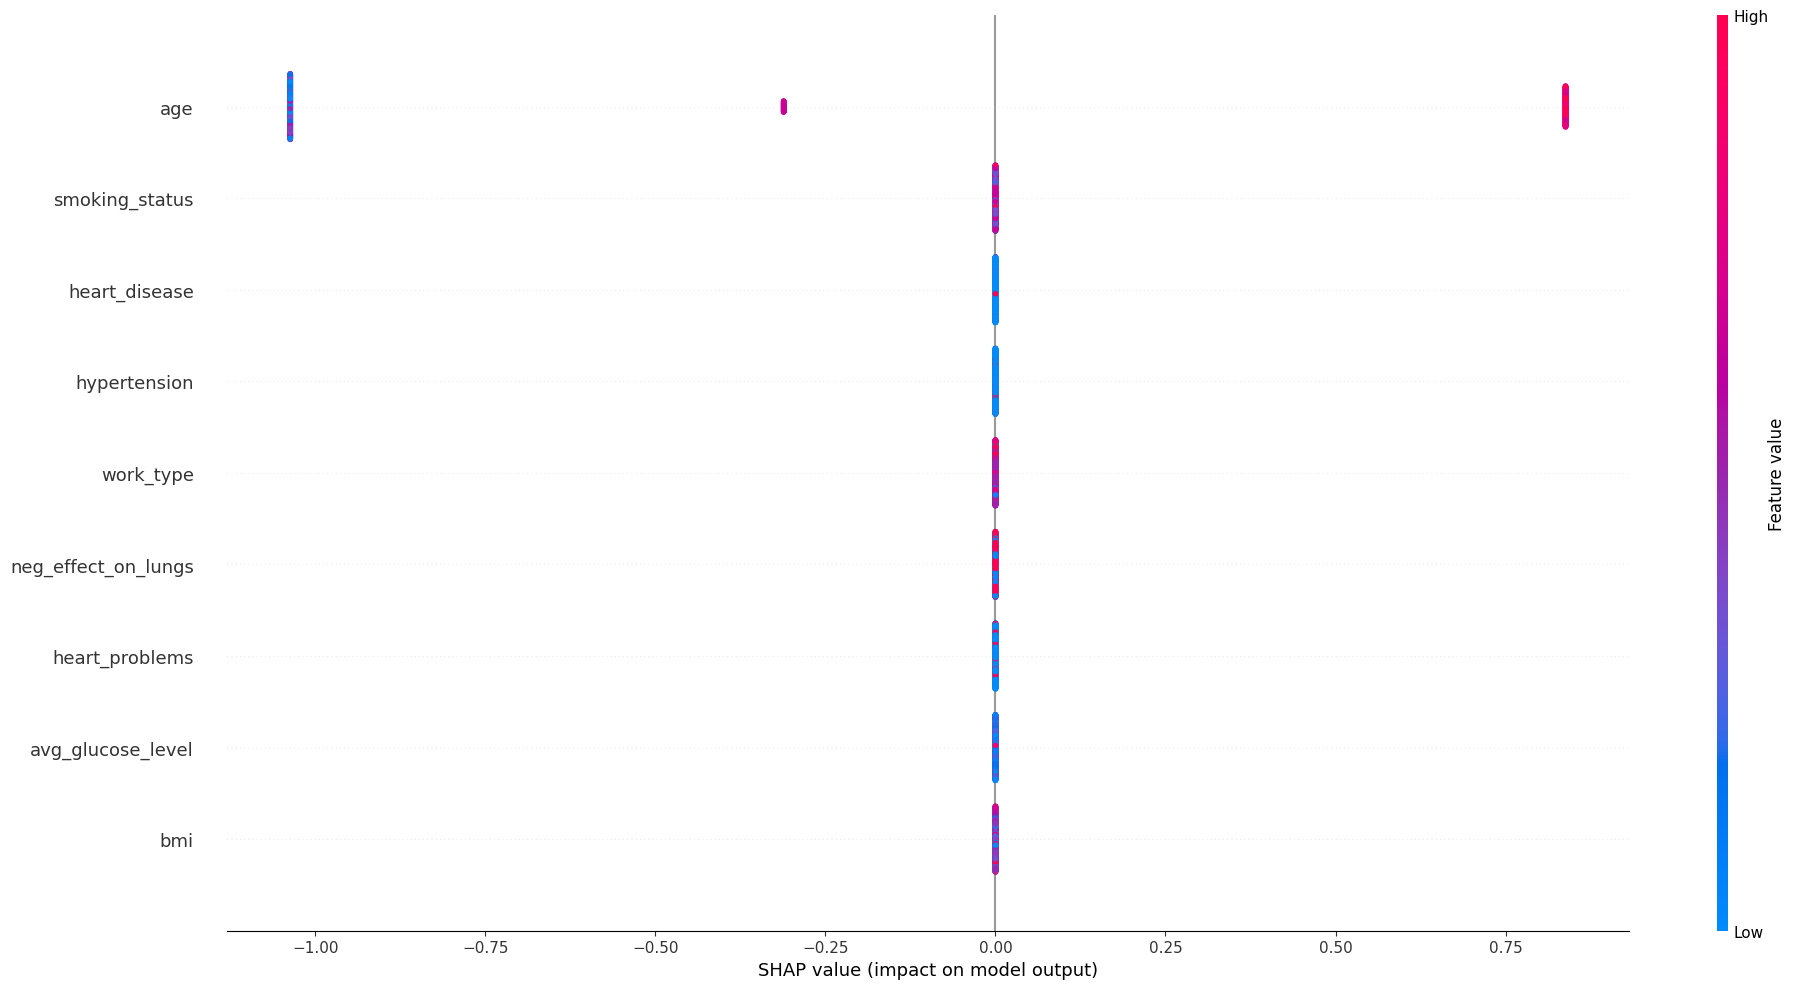

In [750]:
''' Plotting features importances for XGboost '''
shap.summary_plot(
    shap_values, features=observations, feature_names=observations.columns, plot_size=[20, 10]
)

For SVM, we can see better results as it depends on more features and not only age. 

Permutation explainer: 819it [09:11,  1.45it/s]                         


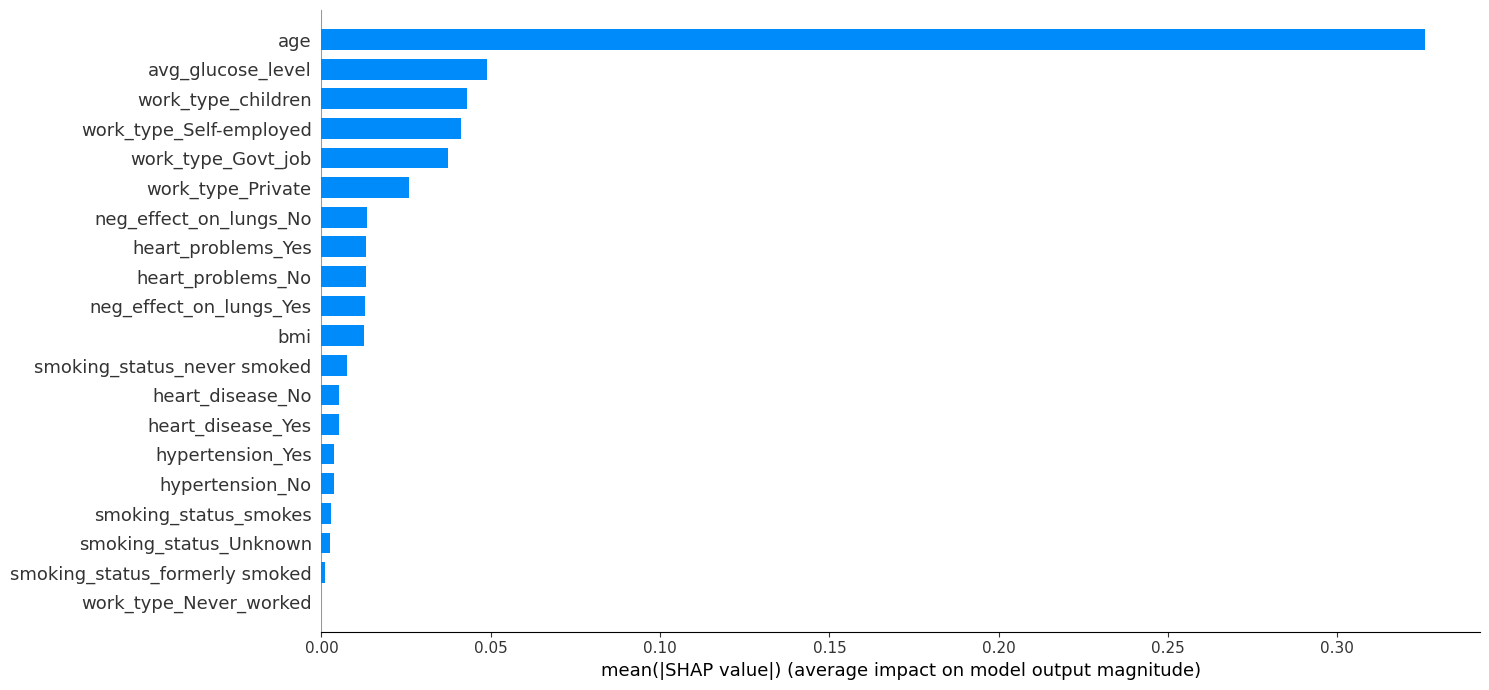

In [751]:
''' Setting shap values for SVM '''
observations = best_svm_model['preprocessor'].transform(x_val)
observations = pd.DataFrame(observations) 
observations.columns = [col[5:] for col in best_svm_model['preprocessor'].get_feature_names_out()]
explainer = shap.Explainer(best_svm_model.named_steps["model"].predict, observations)
shap_values = explainer(observations)
shap.summary_plot(shap_values, observations, plot_type="bar", plot_size=[15,7])
plt.show()

As predicted in the feature exploration, age plays the most important role. Then we have other numeric features such as average glucose level as well. Work type seems to be important value too.

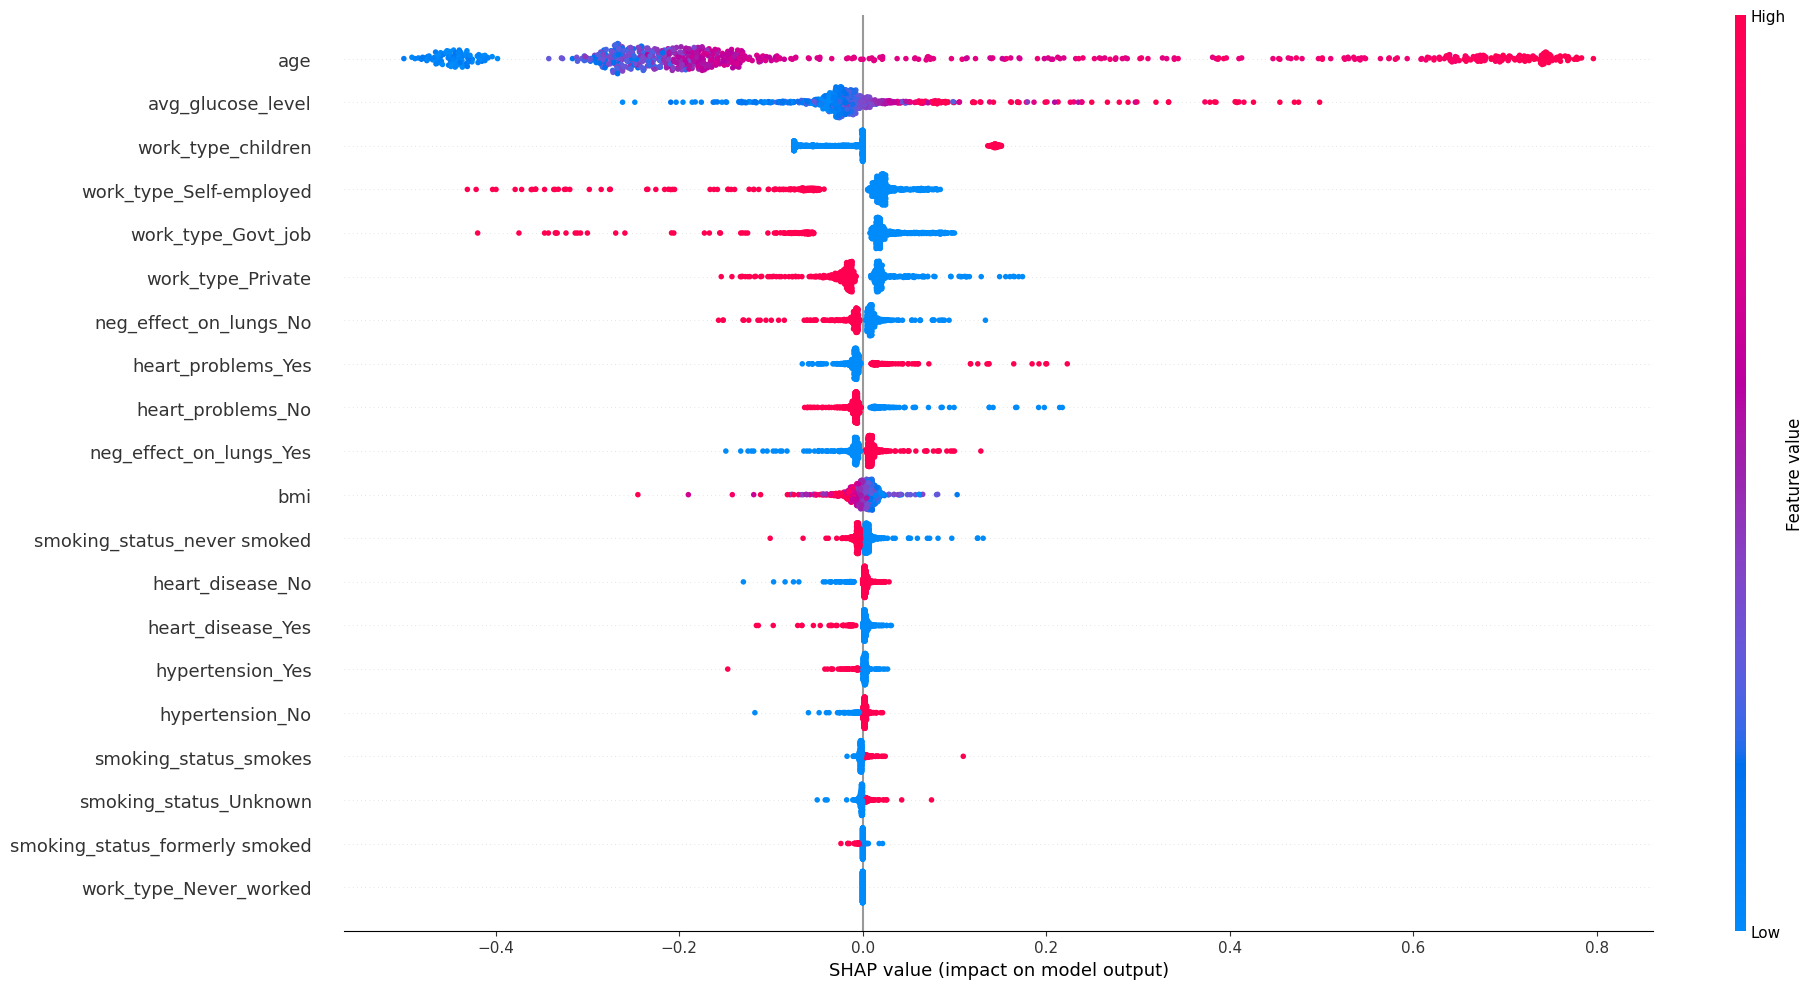

In [752]:
''' Plotting features importances for SVM '''
shap.summary_plot(
    shap_values, features=observations, feature_names=observations.columns, plot_size=[20, 10]
)

## <a id='deploying_model'>5. Deploying Model</a>

Now I will deploy my model in order to use it in FastAPI app! :)

In [753]:
""" Deploying model into joblib file """
dump(best_svm_model, "stroke_classifier.joblib")

['stroke_classifier.joblib']

## <a id='summary'>6. Summary</a>

In this project, I have analysed the stroke dataset. This dataset had very imbalanced stroke class which made the stroke prediction harder. In order to prevent more false negatives, where person with stroke was predicted as one without stroke, I chose recall as my scoring metric. After indepth data exploration I found these observations:

* Mean age was 43.3 and median - 45
* Mean bmi was 28.9 and median - 27.9
* Mean avg_glucose_level was 106.14 and median - 91.88
* In general people with stroke were older than the ones who did not have stroke
    * People WITH stroke mean age was 67.72 and median age was 71.0
    * People WITHOUT stroke mean age was 41.0 and median age was 43.0
* There was not a huge difference between bmi value for people with and without stroke
    * Male WITH stroke median bmi - 28.55
    * Male WITHOUT stroke median bmi - 28.2
    * Female WITH stroke median bmi - 27.9
    * Female WITHOUT stroke median bmi - 27.7
* On general, median avg_glucose_level was higher for people with stroke but it did not have a significant difference.
* Both female and male with stroke had higher avg_glucose_level than those who did not have stroke:
    * Male WITH stroke median avg_glucose_level - 115.435
    * Male WITHOUT stroke median avg_glucose_level - 92.86
    * Female WITH stroke median avg_glucose_level - 97.92
    * Female WITHOUT stroke median avg_glucose_level - 90.54
* There were more people who were married and have stroke but this was due to age difference as children cannot be married and young people tend to be single yet.
* Age for different residence types did not differ and percentage of people with and without stroke in both residential areas did not differ.
* The largest percentage of people with stroke for smoking_status contained the class “formerly smoked” but this is because the age distribution was affecting these results. And other classes such as unknown and never smoked might contain children.

Feature Analysis Results:

* Strongest correlated features:
    * age & ever_married - 0.679084
    * ever_married & bmi - 0.340358
    * age & bmi - 0.332043
    * age & hypertension - 0.276367
    * age & heart_disease - 0.263777

* Features that had strongest Mutual Information score:
    * age - 0.036754
    * bmi - 0.009873
    * work_type - 0.007210
    * ever_married - 0.006945
    * avg_glucose_level - 0.006812

### Conclusions

Machine learning models for predicting stroke are important for Clinical Decision Making because they have the potential to improve the accuracy of stroke risk assessment and help healthcare providers to identify patients who are at high risk of stroke and prioritize them for preventive interventions. By providing more accurate and personalized predictions, these models can help healthcare providers make more informed decisions about patient care, which can ultimately lead to better health outcomes for patients.

However, there are also some setbacks to using machine learning models for predicting stroke. Some of these include:

* **Lack of data**: In this particular project, the data provided was not enough to build a robust model. The final chosen model was SVM which depended on more features than XGBoost which seemed to be overfitting. Machine learning models rely on large amounts of data to make accurate predictions, and there was just not be enough data available to train good models for predicting stroke. Nevertheless, choosing a better threshold was a good solution in order to prevent false negatives and increase recall.

* **Bias**: Machine learning models can also be biased if the data used to train them is not representative of the population, which can lead to inaccurate predictions. In this project, the data was really imbalanced. Oversampling was used to to train model but oversampled data is not organic, therefore, it might just not represent real world scenarios.

* **Regulatory barriers**: There may also be regulatory barriers to using machine learning models for predicting stroke in clinical settings, such as privacy and data protection regulations.

Despite these setbacks, machine learning models for predicting stroke are still a promising tool for Clinical Decision Making, and ongoing research and development is likely to lead to improvements in their accuracy and usability. Machine learning can be a valuable tool in minimizing healthcare costs related to stroke by enabling early detection and prevention. 